# 1. IMPORTING MODULES FOR THE ANALYSIS

In [1]:
import numpy as np ## for working with arrays
import matplotlib.pyplot as plt ## for plotting
%matplotlib inline
import math ## for math
from scipy.interpolate import interp1d ## for interpolating points
import pandas as pd # for dataframe capabilities
import seaborn as sns # for hue and other plotting capabilities
from pylab import * # for color palettes

# for reading in lists of files in folders 
import os
from os import listdir 
from os.path import isfile, join

# for principal component analysis
from sklearn.decomposition import PCA 

# for Kruskal-Wallis test
from scipy import stats

# for posthoc tests
#pip install scikit-posthocs (when installing this is the only line that needs to be in the cell)
import scikit_posthocs as sp

# for curve fitting
from scipy.optimize import curve_fit

# for plotting curved lines
from scipy.interpolate import make_interp_spline

# for Procrustes analysis
from scipy.spatial import procrustes 

## for linear discriminant analysis and LOOCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

# for Spearman Rank correlation
from scipy.stats import spearmanr

## suppress warnings
import warnings
warnings.filterwarnings('ignore')

# 2. DEFINE FUNCTIONS

In [2]:
## function to find indices of a character in a string

def find(s, ch):
    '''
    Defines a function that returns a list of indices where a specific character (ch) 
    is found in a string (s).
    
    Inputs: the string to search and the searched characters
    Outputs: indices where a specific character is found
    '''
    return [i for i, ltr in enumerate(s) if ltr == ch]


def highres_landmarking(landmarks_file, trace_file, resolution):
    '''
    Defines a function to find corresponding index positions of landmarks in the trace file
    and return a trace file at higher resolution with more interpolated points.
    
    Inputs: arrays with x and y coordinates for the landmarks and trace, total resolution to 
            interpolate over
    Outputs: arrays of the indices of the landmarks in the returned modified trace files, now 
            at specified resolution, and x and y coordinates at higher resolution
    '''
    trace_xvals = trace_file[:,0] # specify trace xvals
    trace_yvals = trace_file[:,1] # specify trace yvals

    trace_xvals, trace_yvals = interpolation(trace_xvals,trace_yvals,resolution) # interpolate points to achieve high resolution

    highres_xvals = trace_xvals # copy trace xvals to replace its trace vals with landmark vals
    highres_yvals = trace_yvals # copy trace yvals to replace its trace vals with landmark vals

    land_indices = [] # list to store index values of landmarks in trace

    for i in range(landmarks_file.shape[0]): # for each landmark

        landx = landmarks_file[i,0] # select current landmark x val
        landy = landmarks_file[i,1] # select current landmark y val

        distances = [] # list to store distances of current landmark with each trace coord

        for j in range(len(trace_xvals)): # for each trace coord

            tracex = trace_xvals[j] # current trace x val
            tracey = trace_yvals[j] # current trace y val

            d = np.sqrt( (landx-tracex)**2 + (landy-tracey)**2 ) # find distance to each landmark for each trace

            distances.append(d) # append distance of landmark to each trace val

        min_val = np.min(distances) # find min distance value of a trace for the landmark
        min_ind = distances.index(min_val) # find min index value among trace coords to the landmark

        land_indices.append(min_ind) # append trace index that corresponds to landmark
        
    return land_indices, highres_xvals, highres_yvals


def angle_between(p1, p2, p3):
    '''
    Defines a function to find the angle between 3 points anti-clockwise in degrees, 
    p2 being the vertex and p1 being the left hand of the angle.
    
    Inputs: three angle points, as tuples
    Output: angle in degrees
    '''
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)


def rotate_points(xvals, yvals, degrees):
    '''
    Defines a function to rotate 2D x and y coordinate points around the origin
    
    Inputs: x and y values (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    Outputs: rotated x and y values
    '''
    angle_to_move = 270 - degrees # USE 270 DEGREES TO ORIENT TIP DOWNWARD
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals


def interpolation(x, y, number): 
    '''
    Defines a function to return equally spaced, interpolated points for a given polyline.
    
    Inputs: arrays of x and y values for a polyline, number of points to interpolate
    Ouputs: interpolated points (as arrays) along the polyline, inclusive of start and end points
    '''
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

# 3. DEFINE PARAMETERS AND IMPORT FILES
## 3.1. Define parametres and working directories

In [3]:
## specify folder to read in outlines
out_path = "./03_out/"

## specify folder to read in landmarks
land_path = "./04_land/"

## specify number of interpolated points to use initially
resolution = 10000 

## number of landmarks to interpolate over on each side of the leaflet
num_land = 200

## 3.2. Import files and get file names of imported leaves

The names of the imported files for this next step need to have the format: 

+ land/out_accession_individual number_total node number_node number and letter_leaflet number (example: **out_AM15_3_8_4b_5.txt**)

If your files have different name structure you will need to change the GET LEAF INFO part of the script. 

In [4]:
## retrieve a list of leaf file names
leaf_files = [f for f in listdir(out_path) if isfile(join(out_path, f))] 

## sort the file names alphanumerically 
leaf_files.sort()

## retrieve leaf names
cannabis_leaves = []

for i in range(len(leaf_files)):
    cannabis_leaves.append(leaf_files[i][4:])

## 3.3. Remove the files/folders you want to eliminate

In [5]:
## remove "Store" file
if "Store" in cannabis_leaves:
    cannabis_leaves.remove('Store')

In [6]:
## remove files of leaves that are not modeled correctly   

if 'AM15_4_10_4b_7.txt' in cannabis_leaves: 
    cannabis_leaves.remove('AM15_4_10_4b_7.txt')  
    
if 'AM15_4_10_6b_7.txt' in cannabis_leaves: 
    cannabis_leaves.remove('AM15_4_10_6b_7.txt') 
    
if 'HU1_3_13_13b_7.txt' in cannabis_leaves: 
    cannabis_leaves.remove('HU1_3_13_13b_7.txt') 
    
if 'IKL_1_11_4a_7.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_1_11_4a_7.txt')
    
if 'IKL_1_11_7a_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_1_11_7a_9.txt')  
    
if 'IKL_2_9_7a_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_2_9_7a_9.txt')     
    
if 'IKL_2_9_9a_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_2_9_9a_9.txt')  
    
if 'IKL_2_9_9b_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_2_9_9b_9.txt')  
    
if 'IKL_3_10_6a_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_3_10_6a_9.txt')  
    
if 'IKL_3_10_7a_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_3_10_7a_9.txt')  

if 'IKL_5_12_10b_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_5_12_10b_9.txt')  
    
if 'IKL_5_12_5b_7.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_5_12_5b_7.txt')  
    
if 'IKL_5_12_7b_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_5_12_7b_9.txt')      
    
if 'IKL_5_12_8a_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_5_12_8a_9.txt')  
    
if 'IKL_5_12_9a_9.txt' in cannabis_leaves: 
    cannabis_leaves.remove('IKL_5_12_9a_9.txt')  
    
if 'MN9_2_8_4a_7.txt' in cannabis_leaves: 
    cannabis_leaves.remove('MN9_2_8_4a_7.txt')       

if 'MN9_2_8_5b_7.txt' in cannabis_leaves: 
    cannabis_leaves.remove('MN9_2_8_5b_7.txt')  

# 4. CONVERT THE OUTLINE AND LANDMARK COORDINATES TO POLAR COORDINATES

## 4.1. Loop through the files with landmark and outline coordinates, interpolate the outline coordinates and convert them both to polar coordinates

Here we loop through the files containing the cartesian coordinates of landmarks and leaf outlines (previously obtaines in ImageJ).  
  
We first readin the data and reorder the landmarks, so that they follow as leaflet start, leaflet tip, and leaflet end and petiolar junction separate at the end (this step can be omited if the ladmarks are originally placed in this order).   
We then use the function `highres_landmarking`to an arbitrarily high number of coordinates along the leaf outline to increase resolution (defined above as resolution = 10000). To make sure the landmarks fall perciselly on the leaf outline, the function also finds compares the closest manually selected landmarks in the trace file, against the high-resolution coordinates of the leaf outline and the nearest neighboring point of the high-resolution coordinates to each original landmark is identified and specified as the new landmark point.  
  
We then carry out a 'personalised Procrustes analysis'. With the functions `angle_between` and `rotate_points`, the outline and new landmark coordinates are rotated, and then translated, and scaled so that the central leaflet have a length of one and are pointing in the same direction.

The transformed coordinates then need to be reindexed before starting the conversion to ploar coordinate system. The coordinates are then interpolated to generate 200 pseudo-landmarks on each side of each leaflet, sharing the landmark on the tip of the leaflet (i.e., a total of 399 pseudo-landmarks per leaflet), using the function `interpolation`. These pseudo-landmarks are then converted to polar coordinates, where each point is defined by a radius and angle relative to the petiolar junction and tip of the central leaflet.  
  
The new **high-resolution cartesian coordinates of the outline** are saved in the list **list_reindexed_arr** and the **new reindexed landmarks** are saved in **list_reindexed_landmarks**.

The new **pseudolandmarks** are saved in arrays **interpolated_angles** and **interpolated_radii**. 

In [7]:
# a list of x vals of theoretical leaf with new leaflet number
theor_xvals = []

# a list of y vals of theoretical leaf with new leaflet number
theor_yvals = []

# create lists to store information about leaves
pop_list = []
ind_list = []
tot_list = []
nod_list = []
nodab_list = []
rel_list = []
lob_list = []
interpolated_angles = []
interpolated_radii = []
list_reindexed_arr = []
list_reindexed_landmarks = []

for c in cannabis_leaves:
    # get current leaf file name
    file = c
    print(file)
    
    #######################################################
    #################### GET LEAF INFO ####################
    #######################################################

    ## get underscore indices
    underscores = find(file, "_")

    ## get accession (str)
    population = file[0:underscores[0]]
    pop_list.append(population)

    ## get individual (str) *corrected
    individual = file[0:underscores[1]]
    ind_list.append(individual)

    ## get total node number (int)
    total_num = int(file[(underscores[1]+1):underscores[2]])
    tot_list.append(total_num)

    ## get node ID (str)
    node_id = file[(underscores[2]+1):underscores[3]]

    ## get node number (int)
    node_num = int(node_id[0:-1])
    nod_list.append(node_num)

    ## get relative node number (float)
    rel_node = node_num/total_num
    rel_list.append(rel_node)

    ## get node rep (str)
    node_rep = node_id[-1]
    nodab_list.append(node_rep)

    ## get leaflet number (int)
    lobe_num = int(file[(underscores[3]+1):-4])
    lob_list.append(lobe_num)

    ######################################################
    #################### READ IN DATA ####################
    ######################################################

    ## read in data
    blade_trace = np.loadtxt(out_path+"out_"+file)
    landmarks_readin = np.loadtxt(land_path+"land_"+file)

    ###########################################################
    #################### REORDER LANDMARKS ####################
    ###########################################################

    ## reorder the landmarks file
    # read in as leaflet starts and ends, followed by tips and ending with petiolar junction
    # to reorder we want: for each leaflet start, tip, and end and petiolar junction separate at the end

    ## get petiolar junciton coordinates
    pet_junc = landmarks_readin[-1]

    ## get leaflet base coordinates
    lobe_bases = landmarks_readin[0:lobe_num*2]

    ## get leaflet start coordinates
    lobe_starts = lobe_bases[0::2]

    ## get leaflet end coordinates
    lobe_ends = lobe_bases[1::2]

    ## get leaflet tip coordinates
    lobe_tips = landmarks_readin[lobe_num*2:-1]

    ## reorder landmarks file
    landmarks = np.zeros((lobe_num*3, 2))

    for i in range(lobe_num):
        landmarks[i*3] = lobe_starts[i]
        landmarks[i*3+1] = lobe_tips[i]
        landmarks[i*3+2] = lobe_ends[i]

    ############################################################################################
    #################### FIND LANDMARK INDICES AND CALCULATE HIGH RES TRACE ####################
    ############################################################################################

    # find landmark indices in the trace and return at higher resolution
    land_indices, highres_xvals, highres_yvals = highres_landmarking(landmarks, blade_trace, resolution)

    ##################################################################
    #################### ROTATE, TRANSLATE, SCALE ####################
    ##################################################################

    # rotate so that tip faces downward, translate so that the petiolar junction is at the origin and
    # scale so that the central leaflet is length of 1

    highres_coords = np.column_stack((highres_xvals, highres_yvals)) # create a 2D array of x and y coords

    tip_ind = land_indices[int( ((len(land_indices)/2) + 0.5) - 1 )] # find the tip index value
    start_inds = land_indices[0::3] # find the start index value of each leaflet
    end_inds = land_indices[2::3] # find the end index value of each leaflet
    tip = highres_coords[int(tip_ind)] # get tip coordinates

    # calculate angle between tip, petiolar junction, and a line extending right of petiolar junciton
    angle = angle_between(tip, pet_junc, (pet_junc[0]+1,pet_junc[1]) ) 

    # rotate leaf so that tip points downwards
    rotated_xvals, rotated_yvals = rotate_points(highres_coords[:,0],highres_coords[:,1], angle)

    # calculate coordinates of new rotated petiolar junction to translate leaf to the origin
    origin_x, origin_y = rotate_points(pet_junc[0],pet_junc[1], angle)

    # translate leaf to the origin
    trans_xvals, trans_yvals = rotated_xvals - origin_x, rotated_yvals - origin_y

    # calculate new tip points to scale central leaflet legnth to 1
    tip_x, tip_y = trans_xvals[int(tip_ind)], trans_yvals[int(tip_ind)]

    # calculate central leaflet length, from tip to origin
    central_lobe_len = np.sqrt( (tip_x-0)**2 + (tip_y-0)**2 )

    # calculate scaled coordinate values
    scaled_xvals, scaled_yvals = trans_xvals/central_lobe_len, trans_yvals/central_lobe_len

    # stack scaled coordinates back into a 2D array
    leaf_coords = np.column_stack((scaled_xvals, scaled_yvals)) # create a 2D array of x and y coords

    #############################################################
    #################### REINDEX COORDINATES ####################
    #############################################################

    # reindex the coordinate values so that they begin with the first landmark
    start_coordinate = leaf_coords[land_indices[0]] # save beginning coordinate to double check results

    num_coords = np.shape(leaf_coords)[0] # get number of coordinate values
    zero_index = land_indices[0] # get the zeroth index to start at

    reindexed_arr = np.zeros((num_coords,2)) # array to store new vals

    for i in range(num_coords):
        curr_ind = i # get current index
        new_ind = (i - zero_index)%num_coords # get the new index to use
        reindexed_arr[new_ind,:] = leaf_coords[curr_ind,:] # store the value at the new index position

    # print(start_coordinate, "\n", reindexed_arr[0]) # double check that the start value is now at position 0

    ###########################################################
    #################### REINDEX LANDMARKS ####################
    ###########################################################

    # similar to above, reindex landmarks values the same way

    num_coords = np.shape(leaf_coords)[0] # get number of coordinate values
    zero_index = land_indices[0] # get the zeroth index to start at

    reindexed_landmarks = [] # a list to store new landmark indices

    for i in range(len(land_indices)):
        curr_ind_val = land_indices[i] # get current index
        new_ind_val = (curr_ind_val - zero_index)%num_coords # get the new index to use
        reindexed_landmarks.append(new_ind_val)

    # print(reindexed_landmarks) # double check that results worked

    #####################################################################################
    #################### INTERPOLATE AND CONVERT TO POLAR COORDINATES ####################
    #####################################################################################

    tip_index = num_land - 1 # this will be the index of the tip

    polar_lobe_angles = [] # a list of the angle of each leaflet, from its tip to origin
    polar_angles = [] # a list of lists of the angle values for each leaflet point
    polar_radii = [] # a list of lists of the radii values for each leaflet point

    for j in range(lobe_num): # for the number of leaflets
        lobe_index = j # the index of the leaflet to retrieve, starting at 0

        start_indices = reindexed_landmarks[0::3] # get the leaflet start indices
        tip_indices = reindexed_landmarks[1::3] # get the leaflet tip indices
        end_indices = reindexed_landmarks[2::3] # get the leaflet end indices

        curr_start = start_indices[lobe_index] # for the current leaflet, get the start index
        curr_tip = tip_indices[lobe_index] # for the current leaflet, get the tip index
        curr_end = end_indices[lobe_index] # for the current leaflet, get the end index

        right_side = reindexed_arr[curr_start:curr_tip+1] # get the right side of the leaflet 
        left_side = reindexed_arr[curr_tip:curr_end+1] # get the left side of the leaflet

        # interpolate pseudolandmarks on right side
        right_inter_x, right_inter_y = interpolation(right_side[:,0], right_side[:,1], num_land)
        # interpolate pseudolandmarks on left side
        left_inter_x, left_inter_y  = interpolation(left_side[:,0], left_side[:,1], num_land) 
        
        right_inter = np.column_stack((right_inter_x, right_inter_y)) # recombine right coords
        right_inter = right_inter[0:-1,:] # remove the last value from the last side to avoid duplicate with left
        left_inter = np.column_stack((left_inter_x, left_inter_y)) # recombine left coords

        lobe_pseudos = np.row_stack((right_inter, left_inter)) # combine all leaflet coords together

        lobe_tip = lobe_pseudos[tip_index,:] # set the point of the leaflet tip
        lobe_origin = (0,0) # set the point of the petiolar junction, which is the origin
        ref_point = (0,1) # set the reference point
        
        # get overall leaflet angle and append to list
        polar_lobe_angles.append(angle_between(lobe_tip, lobe_origin, ref_point)) 
       
        lobe_angles = [] # list to store angles of each leaflet point
        lobe_radii = [] # list to store radii of each leaflet point

        for i in range(len(lobe_pseudos)): # for the number of points in the leaflet
            curr_point = lobe_pseudos[i,:] # get the current point

            lobe_angles.append(angle_between(curr_point, lobe_origin, ref_point)) # get point angle and append to list

            lobe_radii.append(np.sqrt((curr_point[0]-0)**2 + (curr_point[1]-0)**2)) # get point radius and append to list

        polar_angles.append(lobe_angles) # append current leaflet angles to polar angles list
        polar_radii.append(lobe_radii) # append current leaflet radii to polar radii list

    # get interpolated angles and radii, a list of lists of points for each leaf by leaflete
    interpolated_angles.append(polar_angles)
    interpolated_radii.append(polar_radii)
    
    # get the list of re-indexed landmarks and outline in the cartesian coordinates
    list_reindexed_landmarks.append(reindexed_landmarks)
    list_reindexed_arr.append(reindexed_arr)    

AM15_3_8_2a_3.txt
AM15_3_8_2b_3.txt
AM15_3_8_3b_5.txt
AM15_3_8_4a_5.txt
AM15_3_8_4b_5.txt
AM15_3_8_5a_7.txt
AM15_3_8_5b_7.txt
AM15_3_8_6a_7.txt
AM15_3_8_6b_7.txt
AM15_3_8_7a_7.txt
AM15_3_8_7b_7.txt
AM15_3_8_8a_7.txt
AM15_3_8_8b_7.txt
AM15_4_10_10a_5.txt
AM15_4_10_2a_3.txt
AM15_4_10_2b_3.txt
AM15_4_10_3a_5.txt
AM15_4_10_3b_5.txt
AM15_4_10_4a_7.txt
AM15_4_10_5a_7.txt
AM15_4_10_5b_7.txt
AM15_4_10_6a_7.txt
AM15_4_10_7a_7.txt
AM15_4_10_7b_7.txt
AM15_4_10_8a_7.txt
AM15_4_10_8b_7.txt
AM15_4_10_9a_7.txt
AM15_4_10_9b_7.txt
AM15_5_9_2a_3.txt
AM15_5_9_3a_3.txt
AM15_5_9_4a_5.txt
AM15_5_9_5a_5.txt
AM15_5_9_5b_5.txt
AM15_5_9_6a_7.txt
AM15_5_9_6b_7.txt
AM15_5_9_7a_7.txt
AM15_5_9_7b_7.txt
AM15_5_9_8a_7.txt
AM15_5_9_8b_7.txt
AM15_5_9_9a_7.txt
AM15_5_9_9b_7.txt
AM15_6_10_10b_5.txt
AM15_6_10_2a_3.txt
AM15_6_10_3a_5.txt
AM15_6_10_3b_3.txt
AM15_6_10_4a_5.txt
AM15_6_10_4b_5.txt
AM15_6_10_5a_7.txt
AM15_6_10_5b_7.txt
AM15_6_10_6a_7.txt
AM15_6_10_6b_7.txt
AM15_6_10_7a_7.txt
AM15_6_10_7b_7.txt
AM15_6_10_8a_7.tx

## 4.2. Discretize relative node into a categorical variable and save as string and as intiger

In [8]:
relnod_list = []

for i in range(len(rel_list)):
    
    curr_val = rel_list[i]
    
    if curr_val <= 0.1:
        relnod_list.append("0.1")
    elif curr_val <= 0.2:
        relnod_list.append("0.2")
    elif curr_val <= 0.3:
        relnod_list.append("0.3")
    elif curr_val <= 0.4:
        relnod_list.append("0.4")
    elif curr_val <= 0.5:
        relnod_list.append("0.5")
    elif curr_val <= 0.6:
        relnod_list.append("0.6")
    elif curr_val <= 0.7:
        relnod_list.append("0.7")
    elif curr_val <= 0.8:
        relnod_list.append("0.8")
    elif curr_val <= 0.9:
        relnod_list.append("0.9")
    elif curr_val <= 1.0:
        relnod_list.append("1.0")

In [9]:
relnod_list_int = []

for i in range(len(rel_list)):
    
    curr_val = rel_list[i]
    
    if curr_val <= 0.1:
        relnod_list_int.append(0.1)
    elif curr_val <= 0.2:
        relnod_list_int.append(0.2)
    elif curr_val <= 0.3:
        relnod_list_int.append(0.3)
    elif curr_val <= 0.4:
        relnod_list_int.append(0.4)
    elif curr_val <= 0.5:
        relnod_list_int.append(0.5)
    elif curr_val <= 0.6:
        relnod_list_int.append(0.6)
    elif curr_val <= 0.7:
        relnod_list_int.append(0.7)
    elif curr_val <= 0.8:
        relnod_list_int.append(0.8)
    elif curr_val <= 0.9:
        relnod_list_int.append(0.9)
    elif curr_val <= 1.0:
        relnod_list_int.append(1.0)

# 5. MODELLING THE ANGLE AND RADIUS AS A FUNCTION OF LEAFLET
## 5.1. MODEL THE ANGLE AND RADIUS AS A FUNCTION OF LEAFLET

Angle and radius as a function of leaflet

**Model $angle$ and $radius$ for each coordinate point as a function of $leaflet$ as a 2nd degree polynomial using the `curve_fit` function from `scipy.optimize`:**

$ angle = a*leaflet^2 +  b*leaflet + c $  
$ radius = a*leaflet^2 +  b*leaflet + c $  

**Inputs:**
1. `interpolated_angles` is a list of lists of lists, the number of leaves x the number of leaflets x angles for each interpolated coordinate (399)
2. `interpolated_radii` is a list of lists of lists, the number of leaves x the number of leaflets x radii for each interpolated coordinate (399)

**Outputs:**
1. `ang_arr` is a 3D array: the number of leaves x the number of coordinates (399) x 3 coefficients for the angle models  
2. `rad_arr` is a 3D array: the number of leaves x the number of coordinates (399) x 3 coefficients for the radii models

In [10]:
num_leaves = len(interpolated_angles) # get number of leaves (341)
coord_num = len(interpolated_angles[0][0]) # get number of coordinates for each leaf (399)

# Create two empty arrays
ang_arr = np.zeros((num_leaves,coord_num,3)) # leaf x coords x 3 coefficients (341, 399, 3)
rad_arr = np.zeros((num_leaves,coord_num,3)) # leaf x coords x 3 coefficients (341, 399, 3)

# create a 2nd degree polynomial function
def polydeg2(xvals, a, b, c):
    return a*(xvals**2) + b*xvals +c

for lf in range(num_leaves): # for each leaf
    
    if lf%20==0:
        print(lf)

    lf_ang = np.array(interpolated_angles[lf]) # array: leaflets x angles for current leaf (7, 399)
    lf_rad = np.array(interpolated_radii[lf]) # array: leaflets x radii for current leaf (7, 399)
    lf_lob = len(lf_ang) # get number of leaflets of current leaf

    # Create models: model angle and radius as a function of leaflet
    # Create two empty arrays
    ang_coef = np.zeros((coord_num,3)) # store 3 coefficients for each leaf
    rad_coef = np.zeros((coord_num,3)) # store 3 coefficients for each leaf

    for coord in range(coord_num): # for each coordinate

        xvals = np.arange(0,lf_lob,1) # calculate x values (the leaflets)
        ang_vals = lf_ang[:,coord] # calculate y values (the angles)
        rad_vals = lf_rad[:,coord] # calculate y values (the radii)

        # calculate parameters for leaf angle and radius models
        ang_par, ang_cov = curve_fit(polydeg2, xvals, ang_vals) # angle as a function of leaflets
        rad_par, ang_cov = curve_fit(polydeg2, xvals, rad_vals) # radius as a function of leaflets

        # store angle and radius coefficients
        ang_coef[coord,:] = ang_par
        rad_coef[coord,:] = rad_par
        
    # store the angle and radius coefficients for the current leaf
    ang_arr[lf,:,:] = ang_coef
    rad_arr[lf,:,:] = rad_coef

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340


## 5.2. Reconstruct all leaves and save them

We have coefficients for 2nd degree models for angle and radius as a function of leaflet. We can model each as a function of leaflet number to reconstruct a theoretical leaf. It is important to note that the reconstructions start with the first real leaflet and end with the last real leaflet. The number of leaflets to reconstruct is equally divided between these two points.

**Inputs:**
1. `lf`: select the leaf to reconstruct
2. `num_leaflets`: select the number of leaflets to reconstruct
3. `ang_arr`: a 3D array: leaves x coordinates x 3 angle model parameters 
4. `rad_arr`: a 3D array: leaves x coordinates x 3 radius model parameters

**Outputs:**
A plot of the reconstructed leaf. For reconstruction, an array `recon_arr` is created, which is a 3D array: number of reconstructed leaflets x coordinates x 2 reconstructed angle and radius values.  
Leaves are stored in a folder names `Recon_leaves_9_lob`

All reconstructed `ang` and `rad` coordinate values are stored in the array `all_recon_arr`, a 4D array:

1. number of leaves x
2. number of RECONSTRUCTED leaflets (not actual leaflet number) x
3. number of coordinates x
4. `ang` and `rad` coordinates values

In [11]:
num_leaflets = 9 # select number of leaflets to reconstruct 

if not os.path.exists("Recon_leaves_9_lob"):
    os.makedirs("Recon_leaves_9_lob")

all_recon_arr = np.zeros((num_leaves,num_leaflets,coord_num,2))

for lf in range(len(interpolated_angles)): # for each leaf
    
    if lf%20==0:
        print(lf)

    num_lobes = len(interpolated_angles[lf]) # get number of leaflets of current leaf
    coord_num = len(interpolated_angles[0][0]) # get number of coordinates for each leaflet

    # calculate leaflet numbers to reconstruct:
    # start on the first real leaflet, index 0
    # ends on the last real leaflet, index the number of leaflets in the leaf -1 (for indexing)
    # specify equal intervals for the desirved number of leaflets to reconstruct using np.linspace()
    leaflet_nums = np.linspace(0,num_lobes-1,num_leaflets)

    # array to hold reconstructed leaflets
    recon_arr = np.zeros((num_leaflets,coord_num,2)) # 3D array: num recon leaflets x coords x ang & rad

    for lft in range(len(leaflet_nums)): # for number of leaflets to reconstruct

        lft_recon = np.zeros((coord_num,2)) # 2D array for current leaflet: coords x ang & rad

        for c in range(coord_num): # for each coordinate

            curr_lft = leaflet_nums[lft] # get current leaflet value to reconstruct

            ang_par = ang_arr[lf,c,:] # get the angle parameters
            rad_par = rad_arr[lf,c,:] # get the radius parameters

            lft_recon[c,0] = polydeg2(curr_lft,ang_par[0],ang_par[1],ang_par[2]) # calculate & store angle value
            lft_recon[c,1] = polydeg2(curr_lft,rad_par[0],rad_par[1],rad_par[2]) # calculate & store radius value

        recon_arr[lft,:,:] = lft_recon # store angle and radius values for coords of current leaflet
        
    all_recon_arr[lf,:,:,:] = recon_arr

    # make a plot of the reconstructed leaf
    for i in range(np.shape(recon_arr)[0]):
        curr_recon = recon_arr[i] # get current reconstructed leaf

        plt.plot(curr_recon[:,0],curr_recon[:,1])
        plt.title(str(cannabis_leaves[lf][:-4])+", "+str(lob_list[lf])+" lobes, relnode "+str(round(rel_list[lf],2)))
        plt.xlabel("Angle")
        plt.ylabel("Radius from petiolar junction")
        plt.xlim(0,360)
    #plt.savefig("./Recon_leaves_9_lob/"+str(lf+1)+"_"+str(cannabis_leaves[lf][:-4])+".jpg")
    plt.close()

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340


## 5.3. Visualise the average leaf for each of the groups
### 5.3.1. Convert the data into a flattened array

In [12]:
# np.shape(all_recon_arr)-(341, 9, 399, 2)
num_leaves = np.shape(all_recon_arr)[0]
num_leaflets = np.shape(all_recon_arr)[1]
num_pseudolands = np.shape(all_recon_arr)[2]
num_cord = np.shape(all_recon_arr)[3]

# create the flattened array
flat_arr_2 = np.reshape(all_recon_arr, (num_leaves, num_leaflets*num_pseudolands,num_cord)) 
#np.shape(flat_arr_2) - (341, 3591, 2)

x_values = flat_arr_2[:, :, 0]
y_values = flat_arr_2[:, :, 1]

flat_arr = np.concatenate((x_values, y_values), axis=1)
#print(np.shape(flat_arr)) # (341, 7182)(first 3591 are x values and second 3591 are y values)

### 5.3.2. Average reconstructed leaf by accession

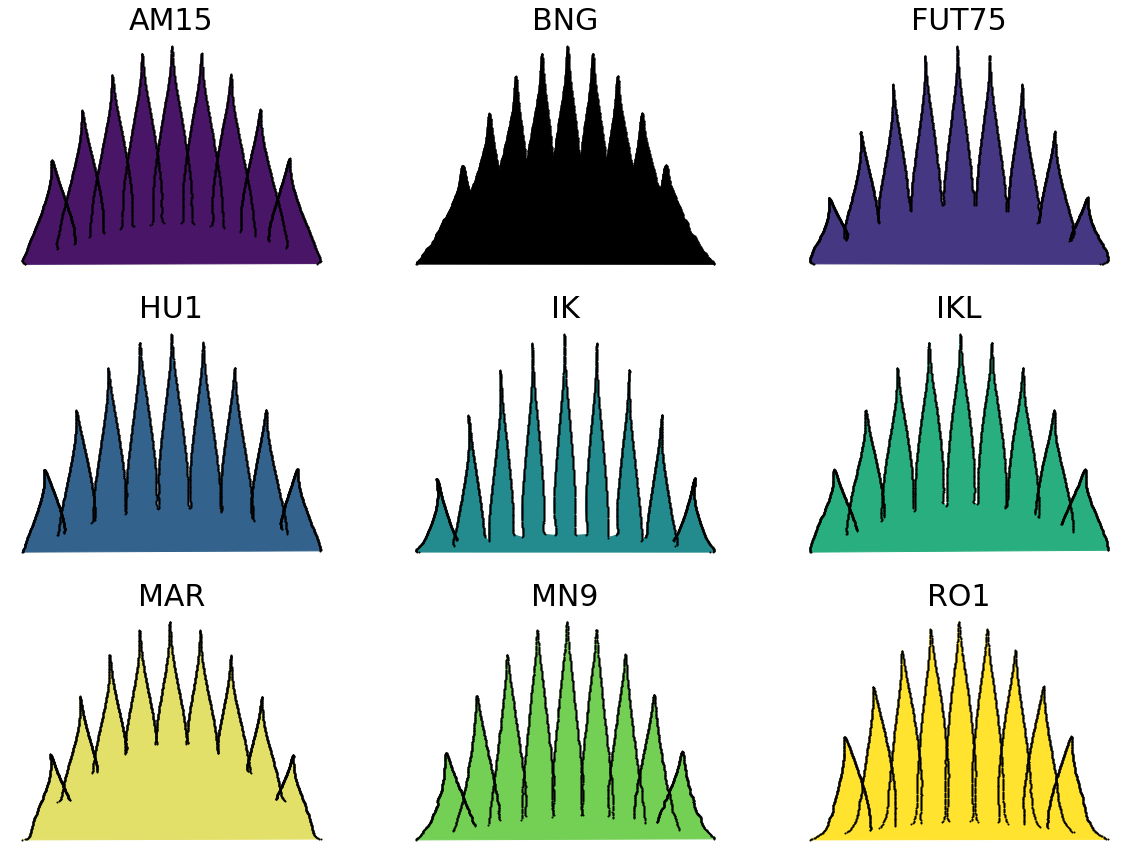

In [13]:
# convert list to arr
pop_arr = np.array(pop_list)

# get unique factor levels to plot
pop_names = np.unique(pop_arr)

# set figure size
plt.figure(figsize=(20,15))

# parameters
fs = 30
plot_colors = ["#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e"]
outline_col = "k"

for i in range(len(pop_names)):

    # get current pop to plot
    curr_pop = pop_names[i]

    # mask pop to plot
    pop_vals = flat_arr[pop_arr==curr_pop]

    # get mean vals
    pop_mean = np.mean(pop_vals, axis=0)

    # get x and y vals
    popx = pop_mean[0:int(len(pop_mean)/2)]
    popy = pop_mean[int(len(pop_mean)/2):]

    # plot
    plt.subplot(3,3,i+1)
    plt.fill(popx, popy,  c=plot_colors[i])
    plt.scatter(popx, popy, c=outline_col, s=1)
    plt.title(curr_pop, fontsize=fs)
    plt.axis("off")     
#plt.suptitle("ACCESSION", fontsize=fs);
#plt.savefig("plot_ACCESSION.pdf", format="pdf")

### 5.3.3. Average reconstructed leaf by leaflet number

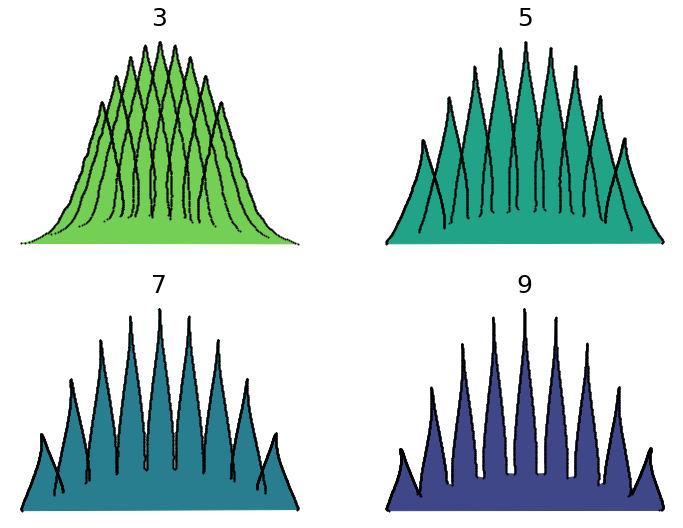

In [14]:
## convert leaflet number to string
lob_str = [str(x) for x in lob_list]

# convert list to arr
lob_arr = np.array(lob_str)

# get unique factor levels to plot
lob_names = np.unique(lob_arr)

# set figure size
plt.figure(figsize=(12,9))

# parameters
fs = 25
plot_colors = ["#73d055", "#20a387", "#287d8e", "#404788"]
outline_col = "k"

for i in range(len(lob_names)):

    # get current leaflet to plot
    curr_lob = lob_names[i]

    # mask leaflet number to plot
    lob_vals = flat_arr[lob_arr==curr_lob]

    # get mean vals
    lob_mean = np.mean(lob_vals, axis=0)

    # get x and y vals
    lobx = lob_mean[0:int(len(lob_mean)/2)]
    loby = lob_mean[int(len(lob_mean)/2):]

    # plot
    plt.subplot(2,2,i+1)
    plt.fill(lobx, loby,  c=plot_colors[i])
    plt.scatter(lobx, loby, c=outline_col, s=1)
    plt.title(curr_lob, fontsize=fs)
    plt.axis("off")  
#plt.suptitle("LEAFLET NUMBER", fontsize=fs);
#plt.savefig("plot_LEAFLETNUMBER.pdf", format="pdf")

### 5.3.4. Average reconstructed leaf by relative node number

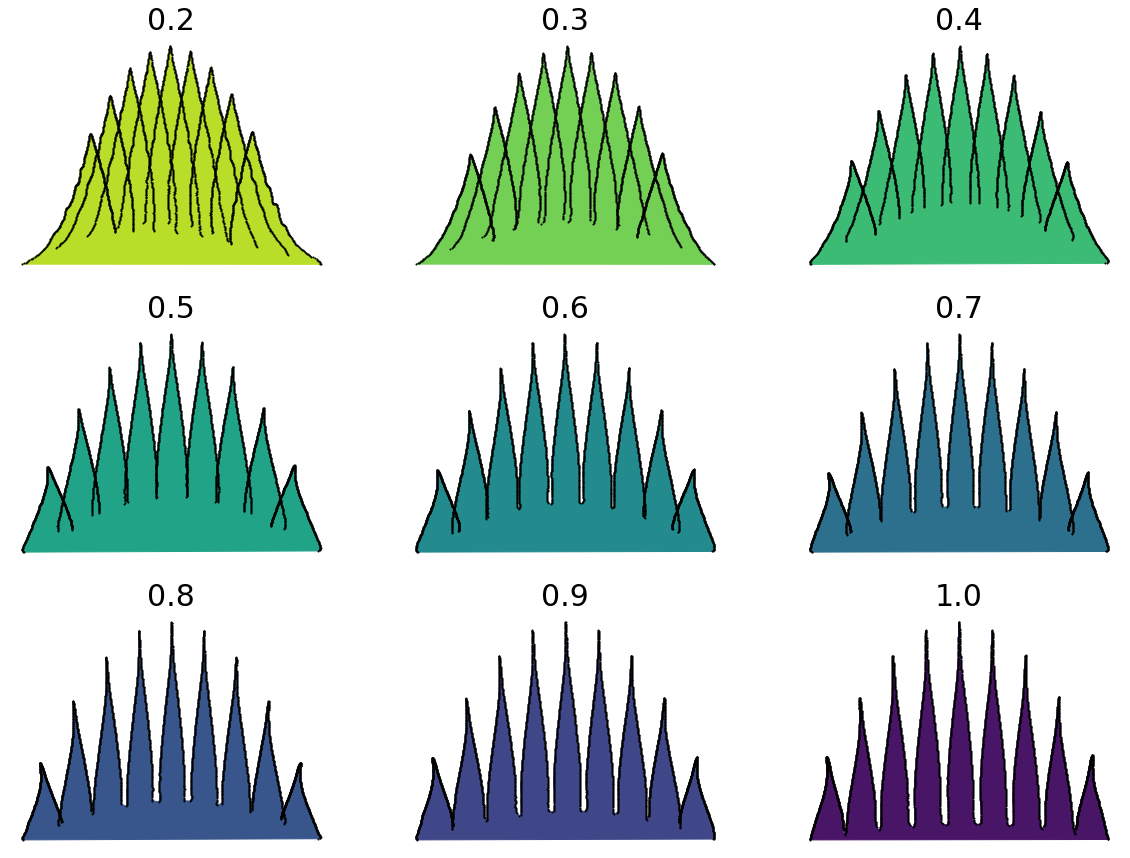

In [15]:
# convert list to arr
rel_arr = np.array(relnod_list)

# get unique factor levels to plot
rel_names = np.unique(rel_arr)

# set figure size
plt.figure(figsize=(20,15))

# parameters
fs = 30
plot_colors = ["#b8de29", "#73d055", "#3cbb75","#20a387", "#238a8d", "#2d708e", "#39568c","#404788", "#481567"]
outline_col = "k"

for i in range(len(rel_names)):

    # get current relative node to plot
    curr_rel = rel_names[i]

    # mask relative node to plot
    rel_vals = flat_arr[rel_arr==curr_rel]

    # get mean vals
    rel_mean = np.mean(rel_vals, axis=0)

    # get x and y vals
    relx = rel_mean[0:int(len(rel_mean)/2)]
    rely = rel_mean[int(len(rel_mean)/2):]

    # plot
    plt.subplot(3,3,i+1)
    plt.fill(relx, rely, c=plot_colors[i])
    plt.scatter(relx, rely, c=outline_col, s=1)
    plt.title(curr_rel, fontsize=fs)
    plt.axis("off")
#plt.suptitle("RELATIVE NODE NUMBER", fontsize=fs);
#plt.savefig("plot_RELATIVENODE.pdf", format="pdf")

# 6. PRINCIPAL COMPONENT ANALYSIS ON COORDINATES OF THE RECONSTRUCTED LEAVES 
## 6.1. Calculate the PCA

In [16]:
num_leaves= len(flat_arr)

# set number of PCs to number of samples, so we can see the percent variance for all PCs
test_pca = PCA(n_components=num_leaves)

# fit a PCA
test_PCs = test_pca.fit_transform(flat_arr) 

# print out explained variance for each PC (a proportion)
print(test_pca.explained_variance_ratio_) 

# print out cumulative variance explained by PC (a proportion)
print(test_pca.explained_variance_ratio_.cumsum()) 

[8.58486400e-01 7.25136470e-02 4.27573005e-02 7.93805565e-03
 6.38049076e-03 3.50096155e-03 1.69420913e-03 1.21168689e-03
 1.18420728e-03 8.93126490e-04 5.11559749e-04 4.16464429e-04
 3.74391708e-04 3.04993747e-04 2.16993448e-04 1.55063188e-04
 1.36300289e-04 9.66683928e-05 9.07802446e-05 6.48904979e-05
 5.19364424e-05 4.71376379e-05 3.92428423e-05 3.80432937e-05
 3.47999718e-05 3.00886212e-05 2.83898331e-05 2.70352381e-05
 2.59815463e-05 2.47346256e-05 2.33366822e-05 2.12103181e-05
 1.93348953e-05 1.87610140e-05 1.83601167e-05 1.72715786e-05
 1.57281343e-05 1.54115097e-05 1.50016208e-05 1.42438293e-05
 1.40783655e-05 1.35819027e-05 1.30313061e-05 1.25029274e-05
 1.19471922e-05 1.14184062e-05 1.13199749e-05 1.08643636e-05
 1.05742559e-05 9.92581333e-06 9.27950209e-06 9.26908920e-06
 9.06928476e-06 8.78333548e-06 8.65128576e-06 8.46342782e-06
 8.17000860e-06 7.74910895e-06 7.59147830e-06 7.40760074e-06
 7.36497739e-06 7.20683046e-06 6.99523575e-06 6.86272925e-06
 6.76333296e-06 6.598447

## 6.2. Plot the PCA and colour by Accession, Leaflet number and Realtive node number

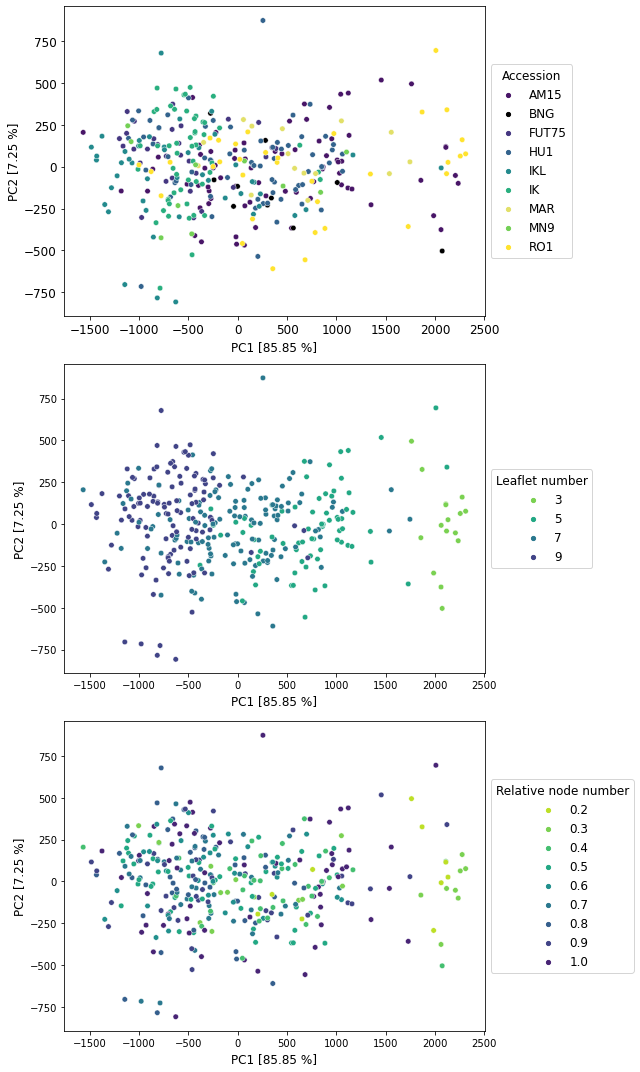

In [17]:
# define number of desired PCs
# for reconstruction, it's easier to just use 2
# but we can use more PC values if desired

pca = PCA(n_components=2)
# apply the sklearn pca function with desired number of components

PCs = pca.fit_transform(flat_arr)

palette_pop=("#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e")
palette_lob=sns.color_palette("viridis_r", 4)
palette_rel_node=sns.color_palette("viridis_r", 9)

pt_s=30
lbs=12
mkscl =0.7

plt.figure(figsize=(9,15))

plt.subplot(3,1,1)
ax=sns.scatterplot(data=PCs, x=PCs[:,0], y=PCs[:,1], s=pt_s, alpha=1, palette= palette_pop, hue=pop_list)
plt.xlabel("PC1 [85.85 %]", fontsize=lbs)
plt.ylabel("PC2 [7.25 %]", fontsize=lbs)
plt.tick_params(labelsize=lbs)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize= lbs, ncol=1, 
                markerscale=mkscl, title="Accession")
plt.setp(ax.get_legend().get_title(), fontsize=lbs)

plt.subplot(3,1,2)
ax=sns.scatterplot(data=PCs, x=PCs[:,0], y=PCs[:,1], s=pt_s, palette= palette_lob, hue=lob_list)
plt.xlabel("PC1 [85.85 %]", fontsize=lbs)
plt.ylabel("PC2 [7.25 %]", fontsize=lbs)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize= lbs, ncol=1, 
                markerscale=mkscl, title="Leaflet number")
plt.setp(ax.get_legend().get_title(), fontsize=lbs)

plt.subplot(3,1,3)
ax=sns.scatterplot(data=PCs, x=PCs[:,0], y=PCs[:,1], s=pt_s, palette=palette_rel_node, hue=relnod_list_int)
plt.xlabel("PC1 [85.85 %]", fontsize=lbs)
plt.ylabel("PC2 [7.25 %]", fontsize=lbs)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize= lbs, ncol=1, 
                markerscale=mkscl, title="Relative node number")
plt.setp(ax.get_legend().get_title(), fontsize=lbs)

plt.tight_layout()
#plt.savefig("pcas_9_leaflets_341_leaves.jpg") 
#plt.savefig("pcas_9_leaflets_341_leaves.pdf", format="pdf") 

## 6.3. Calculate K-W for leaf shape variation along PC1 and PC2 

In [18]:
# Extract the PC1 and PC2
PC1 = test_PCs[:, 0]
PC2 = test_PCs[:, 1]
acc=pop_list 
relnd=relnod_list 
lflt=lob_list

# make a dataframe
data = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'Acc': acc, 'Rel': relnd, 'Leafl': lflt })

In [19]:
# mask accession levels
AM15_PC1 = data["PC1"][data["Acc"]=="AM15"]
BNG_PC1 = data["PC1"][data["Acc"]=="BNG"]
FUT75_PC1 = data["PC1"][data["Acc"]=="FUT75"]
HU1_PC1 = data["PC1"][data["Acc"]=="HU1"]
IKL_PC1 = data["PC1"][data["Acc"]=="IKL"]
IK_PC1 = data["PC1"][data["Acc"]=="IK"]
MAR_PC1 = data["PC1"][data["Acc"]=="MAR"]
MN9_PC1 = data["PC1"][data["Acc"]=="MN9"]
RO1_PC1 = data["PC1"][data["Acc"]=="RO1"]

AM15_PC2 = data["PC2"][data["Acc"]=="AM15"]
BNG_PC2 = data["PC2"][data["Acc"]=="BNG"]
FUT75_PC2 = data["PC2"][data["Acc"]=="FUT75"]
HU1_PC2 = data["PC2"][data["Acc"]=="HU1"]
IKL_PC2 = data["PC2"][data["Acc"]=="IKL"]
IK_PC2 = data["PC2"][data["Acc"]=="IK"]
MAR_PC2 = data["PC2"][data["Acc"]=="MAR"]
MN9_PC2 = data["PC2"][data["Acc"]=="MN9"]
RO1_PC2 = data["PC2"][data["Acc"]=="RO1"]

# Kruskal-Wallis test
print("Kruskal-Wallis test for accession~PC1:", stats.kruskal(AM15_PC1, BNG_PC1, FUT75_PC1, HU1_PC1, IKL_PC1, IK_PC1, MAR_PC1, MN9_PC1, RO1_PC1))
print("Kruskal-Wallis test for accession~PC2:",stats.kruskal(AM15_PC2, BNG_PC2, FUT75_PC2, HU1_PC2, IKL_PC2, IK_PC2, MAR_PC2, MN9_PC2, RO1_PC2))

Kruskal-Wallis test for accession~PC1: KruskalResult(statistic=112.64285063238276, pvalue=1.0892220301064118e-20)
Kruskal-Wallis test for accession~PC2: KruskalResult(statistic=18.5665196110167, pvalue=0.017357937275198285)


In [20]:
# mask Leafl levels
L3_PC1 = data["PC1"][data["Leafl"]==3]
L5_PC1 = data["PC1"][data["Leafl"]==5]
L7_PC1 = data["PC1"][data["Leafl"]==7]
L9_PC1 = data["PC1"][data["Leafl"]==9]

L3_PC2 = data["PC2"][data["Leafl"]==3]
L5_PC2 = data["PC2"][data["Leafl"]==5]
L7_PC2 = data["PC2"][data["Leafl"]==7]
L9_PC2 = data["PC2"][data["Leafl"]==9]

# Kruskal-Wallis test
print("Kruskal-Wallis test for Leafl~PC1:", stats.kruskal(L3_PC1, L5_PC1, L7_PC1, L9_PC1))
print("Kruskal-Wallis test for Leafl~PC2:",stats.kruskal(L3_PC2, L5_PC2, L7_PC2, L9_PC2))

Kruskal-Wallis test for Leafl~PC1: KruskalResult(statistic=204.36154804622038, pvalue=4.816184150563795e-44)
Kruskal-Wallis test for Leafl~PC2: KruskalResult(statistic=10.753281559126208, pvalue=0.013137596705839742)


In [21]:
# mask relative node levels
R2_PC1 = data["PC1"][data["Rel"]=="0.2"]
R3_PC1 = data["PC1"][data["Rel"]=="0.3"]
R4_PC1 = data["PC1"][data["Rel"]=="0.4"]
R5_PC1 = data["PC1"][data["Rel"]=="0.5"]
R6_PC1 = data["PC1"][data["Rel"]=="0.6"]
R7_PC1 = data["PC1"][data["Rel"]=="0.7"]
R8_PC1 = data["PC1"][data["Rel"]=="0.9"]
R9_PC1 = data["PC1"][data["Rel"]=="0.9"]
R10_PC1 = data["PC1"][data["Rel"]=="1.0"]

R2_PC2 = data["PC2"][data["Rel"]=="0.2"]
R3_PC2 = data["PC2"][data["Rel"]=="0.3"]
R4_PC2 = data["PC2"][data["Rel"]=="0.4"]
R5_PC2 = data["PC2"][data["Rel"]=="0.5"]
R6_PC2 = data["PC2"][data["Rel"]=="0.6"]
R7_PC2 = data["PC2"][data["Rel"]=="0.7"]
R8_PC2 = data["PC2"][data["Rel"]=="0.9"]
R9_PC2 = data["PC2"][data["Rel"]=="0.9"]
R10_PC2 = data["PC2"][data["Rel"]=="1.0"]

# Kruskal-Wallis test
print("Kruskal-Wallis test for relative node~PC1:", stats.kruskal(R2_PC1, R3_PC1, R4_PC1, R5_PC1, R6_PC1, R7_PC1, R8_PC1, R9_PC1, R10_PC1))
print("Kruskal-Wallis test for relative node~PC2:", stats.kruskal(R2_PC2, R3_PC2, R4_PC2, R5_PC2, R6_PC2, R7_PC2, R8_PC2, R9_PC2, R10_PC2))

Kruskal-Wallis test for relative node~PC1: KruskalResult(statistic=49.727450611363594, pvalue=4.610378866467573e-08)
Kruskal-Wallis test for relative node~PC2: KruskalResult(statistic=2.9808735212835975, pvalue=0.9355520892614743)


# 7. PROCRUSTES ANALYSIS OF RECONSTRUCTED CENTRAL LEAFLETS AND MODEL VALIDATION

## 7.1. Extracting the (polar) coordinates of central leaflets of original leaves

In [22]:
# Extract the polar coordinates (angles and radii) for the central leaflet from the original leaves

central_coord_ang =[]
central_coord_rad =[]

for i in range(len(interpolated_angles)):
    num_lobes = len(interpolated_angles[i])
    central_lobe = int((num_lobes/2) - 0.5)
    curr_ang = interpolated_angles[i][central_lobe]
    curr_rad = interpolated_radii[i][central_lobe]
    central_coord_ang.append(curr_ang)
    central_coord_rad.append(curr_rad)
        
central_coord_orig = np.stack((central_coord_ang, central_coord_rad), axis=-1) # shape: (341, 399, 2)
#np.shape(central_coord_orig)

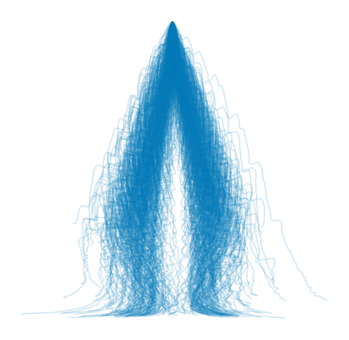

In [23]:
# check that is is stored OK
plt.figure(figsize=(6,6))
for i in range(len(central_coord_orig)):
    plt.plot(central_coord_orig[i][:, 0], central_coord_orig[i][:, 1], c="#0077B6", alpha=0.15)
plt.axis("off");
#plt.savefig("polar_cent_leaves.pdf", format="pdf")

## 7.2. Extracting the (polar) coordinates of central leaflets of reconstructed leaves

In [24]:
# Extract the reconstructed polar coordinates (angles and radii) for the central leaflet
central_recon_coord = [] 

c_leaflet = int((num_leaflets/2) - 0.5)

for i in range(len(all_recon_arr)):
    curr_coor = all_recon_arr[i][c_leaflet]
    central_recon_coord.append(curr_coor)
#np.shape(central_recon_coord) # shape: (341, 399, 2)    

In [25]:
# convert central_recon_coord to a 3D array
central_recon_coord = np.array(central_recon_coord)

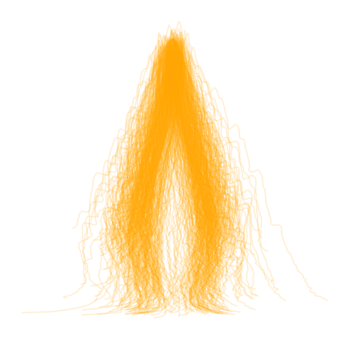

In [26]:
# check that is is stored OK
plt.figure(figsize=(6,6))
for i in range(len(central_recon_coord)):
    plt.plot(central_recon_coord[i][:, 0], central_recon_coord[i][:, 1], c="orange", alpha=0.15)
plt.axis("off");
#plt.savefig("polar_reconst_cent_leaves.pdf", format="pdf")

The two lists with comparable coordinates are:

1. **central_coord_orig**  
The coordinates of original leaves. Shape: 341, 399, 2
2. **central_recon_coord**  
The coordinates of reconstructed leaves. Shape: 341, 399, 2

## 7.3. Procrustes analysis of reconstructed central leaflets and model validation
For a set of landmarks, Procrustes analysis minimizes the distance between all points between two samples through translation, rotation, and scaling. Procrustes analysis returns: 
1) the new points of the two sets superimposed to each other and   
2) the overall distance between them, a measure of their similarity.

In order to validate our modeling approach we will: 
1) calculate the Procrustes distance between the original central leaflet angle and radius coordinate data to its corresponding modeled reconstruction;  
2) the mean distance will then be compared to that of simulated bootstrapped mean values by resampling through randomly sorting orignal leaflet coordinates against reconstructed coordinates.  

Calculate distances between all original and reconstructed central leaflet pairs:

In [27]:
distances = []

for i in range(np.shape(central_coord_orig)[0]):

    curr_orig = central_coord_orig[i] # select original central leaflet
    curr_recon = central_recon_coord[i] # select reconstructed central leaflet

    # calculate procrustes superimposition for each leaflet and their distance
    s1, s2, d = procrustes(curr_orig, curr_recon) 
    
    distances.append(d) # store the current Procrustes distance
    
proc_mean = np.mean(distances) # calculate mean distance value

print("The Procrustes mean is", proc_mean) # print mean value

The Procrustes mean is 0.012979897883732456


Resample through random sorting/shuffling the reconstructed leaflets against the original leaflets. Calculate the new Procrustes mean value for each resample. For n resamples, compare the distribution of mean values against the real Procrustes mean value.

In [28]:
#resamples = 200 # number of resamplings to perform when testing
resamples = 10000 # number of resamplings to perform fot the final analysis

resample_mean_vals = [] # store mean values of resampled analyses

for n in range(resamples): # for the number of resamples
    
    if n%100==0:
        print(n)
    
    copy_recon = np.copy(central_recon_coord) # create a copy of the reconstructed leaflets
    np.random.shuffle(copy_recon) # randomly shuffle the reconstructed leaflets
    
    distances_r = [] # create a list to store distances

    for i in range(np.shape(central_coord_orig)[0]): # for each leaf

        curr_orig = central_coord_orig[i] # select original central leaflet
        curr_recon = copy_recon[i] # select resampled reconstructed central leaflet

        # calculate procrustes superimposition for each leaflet and their distance
        s1, s2, d = procrustes(curr_orig, curr_recon) 

        distances_r.append(d) # store the current Procrustes distance

    resample_mean = np.mean(distances_r) # calculate the resampled mean distance value
    resample_mean_vals.append(resample_mean) # append resampled mean value

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


Calculate how many resampled means are less than the actual Procrustes mean value?

In [29]:
# convert to array to mask
resample_mean_vals_arr = np.array(resample_mean_vals) 

# calculate number lower than
number_lower_than = len(resample_mean_vals_arr[resample_mean_vals_arr<proc_mean])
print("Out of", resamples, "resamples, ", number_lower_than, 
      "are lower than the actual mean Procrustes value.")

Out of 10000 resamples,  0 are lower than the actual mean Procrustes value.


Plot the resampled distribution of means against the actual Procrustes mean. The actual Procrustes mean is represented as a vertical line, the resampled means a distribution as a histogram

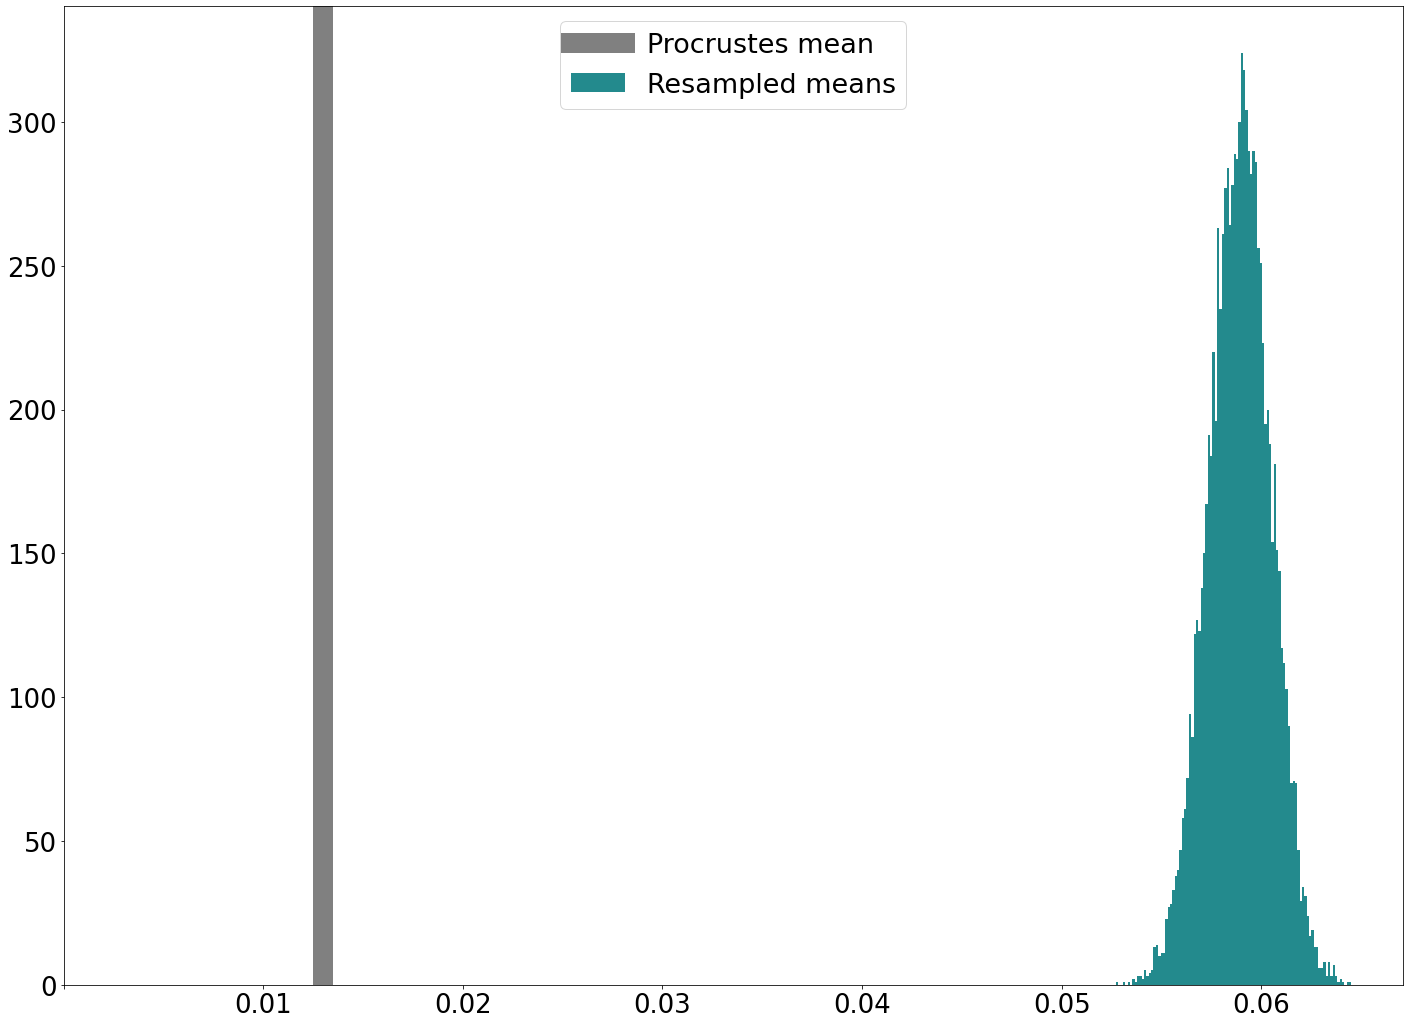

In [30]:
plt.figure(figsize=(24,18))
plt.axvline(x=proc_mean, ymin=0, ymax=1, c="grey", lw=20, alpha=1, label="Procrustes mean")
plt.hist(resample_mean_vals, bins=100, color="#238a8d", label="Resampled means")
custom_ticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]  # Adjust as needed
custom_labels = ["", "0.01", "0.02", "0.03", "0.04", "0.05", "0.06"]  # Adjust as needed
plt.xticks(custom_ticks, custom_labels)
plt.tick_params(labelsize=26)
plt.legend(loc='center', bbox_to_anchor=(0.9, 0.94, -0.8, 0.0), fontsize= 27)
#plt.savefig("procrustees_histo.pdf", format="pdf", bbox_inches='tight')

# 8. LINEAR DISCRIMINANT ANALYSIS ON TRANSFORMED LEAVES
## 8.1. Convert the coordinates of the transformed leaves into a flattened array

In [82]:
# flatten the coordinate array
flat_coord_arr = np.reshape(all_recon_arr,
                            (np.shape(all_recon_arr)[0], 
                             np.shape(all_recon_arr)[1]*np.shape(all_recon_arr)[2]*np.shape(all_recon_arr)[3]))
#np.shape(flat_coord_arr) # shape: (341, 7182)

## 8.2. The LDA analysis for Accessions

In [32]:
## x is the features we use to predict factor - they are the modeled x and y coordinate values for transformed leaves
x_pop = flat_coord_arr

## y is the factor we are predicting - in this case it is accession
y_pop = pop_list

## we create an LDA model for accession from coordiate values and then we fit the model
pop_model = LinearDiscriminantAnalysis()
pop_model.fit(x_pop, y_pop)

## calculate the LDs from the model
pop_LDs = pop_model.fit(x_pop, y_pop).transform(x_pop)

## create a df to plot the data
popLD_df = pd.DataFrame({'LD1':pop_LDs[:,0], 
                      'LD2':pop_LDs[:,1], 
                      'pop':pop_list})

**Leave-One-Out Cross-Validation**

In [33]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_pop = cross_val_score(pop_model, x_pop, y_pop, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_pop), std(scores_pop)))

Accuracy: 0.724 (0.447)


## 8.3. The LDA analysis for Leaflet number

In [34]:
## x is the features we use to predict factor - they are the modeled x and y coordinate values for transformed leaves
x_lob =  flat_coord_arr

## y is the factor we are predicting - in this case it is leaflet number
## convert leaflet number to string
y_lob = [str(x) for x in lob_list]

## we create an LDA model for leaflet number from coordiate values and then we fit the model
lob_model = LinearDiscriminantAnalysis()
lob_model.fit(x_lob, y_lob)

## calculate the LDs from the model
lob_LDs = lob_model.fit(x_lob, y_lob).transform(x_lob)

## create a df to plot the data
lobLD_df = pd.DataFrame({'LD1':lob_LDs[:,0], 
                      'LD2':lob_LDs[:,1], 
                      'lob':y_lob})

**Leave-One-Out Cross-Validation**

In [35]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_lob = cross_val_score(lob_model, x_lob, y_lob, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_lob), std(scores_lob)))

Accuracy: 0.997 (0.054)


## 8.4. The LDA analysis for Relative node number

In [36]:
## x is the features we use to predict factor - they are the modeled x and y coordinate values for transformed leaves
x_rel = flat_coord_arr

## y is the factor we are predicting - in this case it is relative node number
y_rel = relnod_list

## we create an LDA model for relative node number from coordiate values and then we fit the model
rel_model = LinearDiscriminantAnalysis()
rel_model.fit(x_rel, y_rel)

## calculate the LDs from the model
rel_LDs = rel_model.fit(x_rel, y_rel).transform(x_rel)

## create a df to plot the data
relLD_df = pd.DataFrame({'LD1':rel_LDs[:,0], 
                      'LD2':rel_LDs[:,1], 
                      'rel':y_rel})

**Leave-One-Out Cross-Validation**

In [37]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_rel = cross_val_score(rel_model, x_rel, y_rel, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_rel), std(scores_rel)))

Accuracy: 0.284 (0.451)


# 9. PREDICTION ON TRAIN (a) AND TEST (b) DATASETS
## 9.1. Prepare the data

In [38]:
# Extract the indexes of where leaves with a and c and leaves with b and d are found and save them in a new list of 
# indexes for leaves ind_a and ind_b and check the length

def find_ac(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch or ltr == 'c']

def find_bd(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch or ltr == 'd']

leaf_a = find_ac(nodab_list, "a")
leaf_b = find_bd(nodab_list, "b")
#print(len(nodab_list))
#print(len(leaf_a))
#print(len(leaf_b))
#print(len(leaf_a) + len(leaf_b))

In [39]:
## Extract the rows with the x and y coordinate values for with leaves a and b into a separate array.
new_arr_a = flat_coord_arr[leaf_a]
new_arr_b = flat_coord_arr[leaf_b]

## Check the new structures of lists and arrays to make sure :)
#print(len(leaf_a), len(leaf_b))
#print(len(new_arr_a), len(new_arr_b))    
#print(type(new_arr_a), type(new_arr_b) 
#print(new_arr_a.shape, new_arr_b.shape)

In [40]:
# Then we need to extract the data from the lists we will use as y test dataset

pop_list_a = [pop_list[i] for i in leaf_a]
pop_list_b = [pop_list[i] for i in leaf_b]
#print(len(pop_list_a), len(pop_list_b)) 

relnod_list_a = [relnod_list[i] for i in leaf_a]
relnod_list_b = [relnod_list[i] for i in leaf_b]
#print(len(relnod_list_a), len(relnod_list_b)) 

lob_list_a = [lob_list[i] for i in leaf_a]
lob_list_b = [lob_list[i] for i in leaf_b]
#print(len(lob_list_a), len(lob_list_b)) 

## 9.2. Train the model on a and predict the b leaves and plot confusion matrix
### 9.2.1. By Accession

In [41]:
## x is the features we use to predict factor - they are the modeled x and y coordinate values for transformed leaves
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting - in this case it is accession
y_a = pop_list_a
y_b = pop_list_b

## we create an LDA model for accession from coordiate values and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_pop= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_pop)]

count_true_pa = comparison_result.count(True)
count_false_pa = comparison_result.count(False)
print("Count of True values for accession:", count_true_pa)
print("Count of False values for accession:", count_false_pa)

## Data for plotting a confusion matrix

# True values
true_values = pop_list_b

# Predicted values
predicted_values = prediction_pop

# Create confusion matrix
cm_pop = confusion_matrix(true_values, predicted_values)

Count of True values for accession: 118
Count of False values for accession: 43


### 9.2.2. By Leaflet number

In [42]:
## x is the features we use to predict factor - they are the modeled x and y coordinate values for transformed leavess
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting - in this case it is leaflet number
y_a = lob_list_a
y_b = lob_list_b

## we create an LDA model for leaflet number from coordiate values and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_lob= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_lob)]

count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("Count of True values for leaflet number:", count_true_pl)
print("Count of False values for leaflet number:", count_false_pl)

## Data for plotting a confusion matrix

# True values
true_values = lob_list_b

# Predicted values
predicted_values = prediction_lob

# Create confusion matrix
cm_lob = confusion_matrix(true_values, predicted_values)

Count of True values for leaflet number: 160
Count of False values for leaflet number: 1


### 9.2.3. By Relative node number

In [43]:
## x is the features we use to predict factor - they are the modeled x and y coordinate values for transformed leaves
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting - in this case it is relative node number
y_a = relnod_list_a
y_b = relnod_list_b

## we create an LDA model for relative node number from coordiate values and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_relnod= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_relnod)]

count_true_pr = comparison_result.count(True)
count_false_pr = comparison_result.count(False)
print("Count of True values for relative node:", count_true_pr)
print("Count of False values for relative node:", count_false_pr)

## Data for plotting a confusion matrix

# True values
true_values = relnod_list_b

# Predicted values
predicted_values = prediction_relnod

# Create confusion matrix
cm_rel = confusion_matrix(true_values, predicted_values)

Count of True values for relative node: 55
Count of False values for relative node: 106


**And calculate Spearman Rank correlation**#calculate Spearman Rank correlation and corresponding p-value

In [44]:
rho, p = spearmanr(relnod_list_b, prediction_relnod)

#print Spearman rank correlation and p-value
print(rho)
print(p)
rho_p = rho
p_p = p

0.7466880247024108
5.916349072142989e-30


## 9.3. Plot the LDAs and Confusion matrices for leaves modeled with 2nd polynomial models

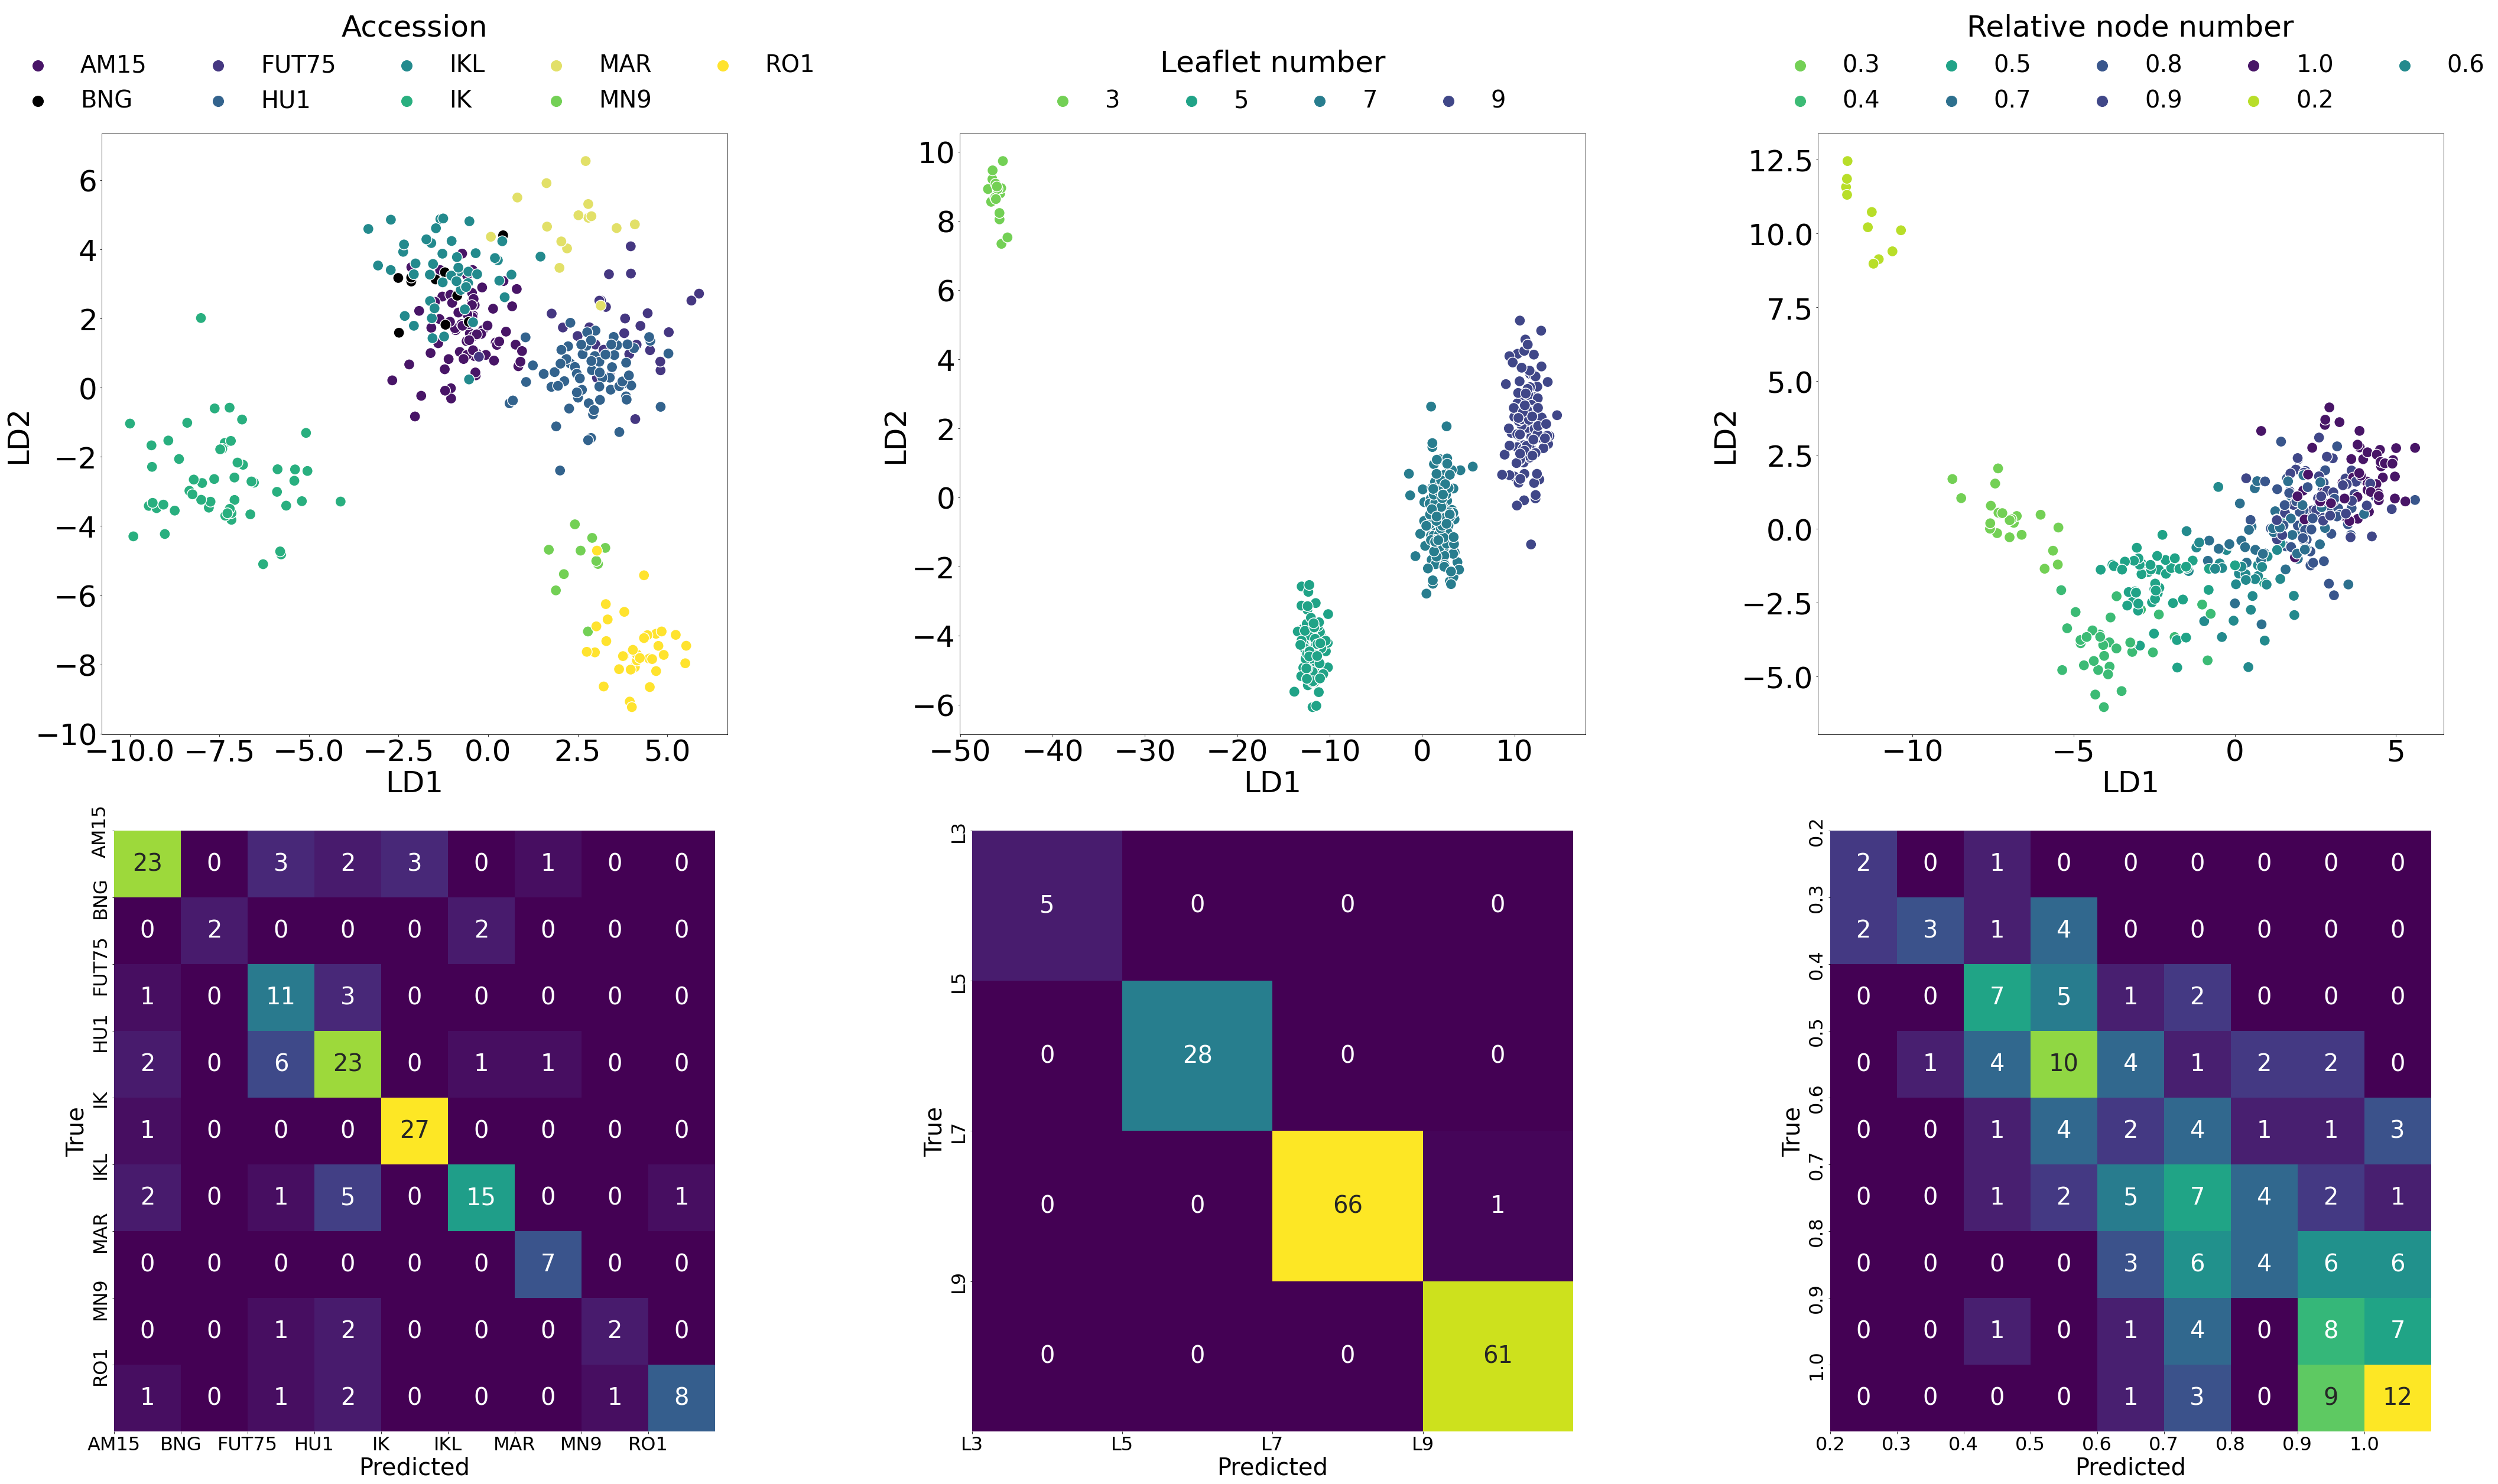

In [45]:
palette_pop=("#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e")
palette_lob=("#73d055", "#20a387", "#287d8e", "#404788")
palette_rel_node=("#73d055", "#3cbb75", "#20a387", "#2d708e", "#39568c", "#404788", "#481567", "#b8de29", "#238a8d")

# Parameters for LDAs
pt_s=330
lbs=50
mkscl=3
lbs_leg=40

# Parameters for Confusion matrices
fs=40
ls=32
fs_m=40

plt.figure(figsize=(60,35))

plt.subplot(2,3,1)
ax=sns.scatterplot(data=popLD_df, x="LD1", y="LD2", hue="pop", s=pt_s, palette=palette_pop, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Accession", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 

plt.subplot(2,3,2)
ax=sns.scatterplot(data=lobLD_df, x="LD1", y="LD2", hue="lob", s=pt_s, palette=palette_lob, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Leaflet number", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 

plt.subplot(2,3,3)
ax=sns.scatterplot(data=relLD_df, x="LD1", y="LD2", hue="rel", s=pt_s, palette=palette_rel_node, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Relative node number", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 

plt.subplot(2,3,4)
ax=sns.heatmap(cm_pop, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Adjust as needed
custom_labels_y = ["AM15", "BNG", "FUT75", "HU1", "IK", "IKL", "MAR", "MN9", "RO1"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.subplot(2,3,5)
ax=sns.heatmap(cm_lob, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3]  # Adjust as needed
custom_labels_y = ["L3", "L5", "L7", "L9"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.subplot(2,3,6)
ax=sns.heatmap(cm_rel, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Adjust as needed
custom_labels_y = ["0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.tight_layout()
#plt.savefig("lda_conf_matrix_polynomials.jpg")
#plt.savefig("lda_conf_matrix_polynomials.pdf", format="pdf", bbox_inches='tight')

# 10. COMPARISON WITH THE TRADITIONAL METHOD (width/length measurement)
## 10.1. Extract and interpolate the coordinates of the central leaflets of the original leaves

In [46]:
### The Option with the central leaflets in 'original' but scaled, translated and rotated coordinates 
###  + INTERPOLATION TO 200 POINTS ON EACH SIDE

c_lob_index_interpolation =[]  # Initialize a list to store the index coordinates of start, tip and end pseudolandmarks 
                      # of central leaflets[[6, 7, 8], [9, 10, 11],...
    
for i in range(len(lob_list)):  #341
 
    # get number of leaflets (like this you extract the leaflet number for each of the 341 leaves)
    lobe_number = len(list_reindexed_landmarks[i])
        
    # get index of the three landmarks in the central leaflet
    c_lobe_st = int((lobe_number/2) - 1.5)
    c_lobe_tip = int((lobe_number/2) - 0.5)
    c_lobe_end = int((lobe_number/2) + 0.5)
    temp_list_interpolation = [c_lobe_st, c_lobe_tip, c_lobe_end]
    c_lob_index_interpolation.append(temp_list_interpolation)
    
c_lob_interpolation_ind = []  # Initialize a list to store the 341 arrays with extracted indices of the start, tip and end 
                              # of central leaflet [[3531, 4930, 6315], [3602, 4756, 6027],....

for i in range(len(lob_list)):    # 341
    central_indices_interpolation = c_lob_index_interpolation[i]  # Get indices of the landmarks for start, tip and end of 
                                                                  # central leaflet for the i-th element    
    landmarks = list_reindexed_landmarks[i]  # Get all the indices for all the landmarks for the i-th element
    
    # Extract the indices for start, tip and end of the central leaflet in the file of the outline coordinates 
    # and append them to c_lob_interpolation_ind
    extracted_values_interpolation = [landmarks[index] for index in central_indices_interpolation]
    c_lob_interpolation_ind.append(extracted_values_interpolation)
    
list_right_side_corr = [] # list of 341 leaves with a different number of xy coordinates for right side of central leaflet
list_left_side_corr = []  # list of 341 leaves with a different number of xy coordinates for left side of central leaflet
list_central_lobe_interpolated = []  ## list of 341 leaves with a each of the 399 xy coordinates for both right and left side 
                                     ## of central leaflet (the coordinates are for leaves that are scalled, rotated and 
                                     ## translated)

for i in range(len(c_lob_interpolation_ind)):    # 341
    curr_start = c_lob_interpolation_ind[i][0] # for the current leaflet, get the start index
    curr_tip = c_lob_interpolation_ind[i][1] # for the current leaflet, get the tip index
    curr_end = c_lob_interpolation_ind[i][2] # for the current leaflet, get the end index
    
    right_side = list_reindexed_arr[i][curr_start:curr_tip+1] # get the right side of the leaflet 
    left_side = list_reindexed_arr[i][curr_tip:curr_end+1] # get the left side of the leaflet
    list_right_side_corr.append(right_side)
    list_left_side_corr.append(left_side)
    
    right_interpolated_x, right_interpolated_y = interpolation(right_side[:,0], right_side[:,1], num_land)
    left_interpolated_x, left_interpolated_y = interpolation(left_side[:,0], left_side[:,1], num_land)
    
    right_interpolated = np.column_stack((right_interpolated_x, right_interpolated_y)) # recombine right coords
    right_interpolated = right_interpolated[0:-1,:] # remove the last value from the last side to avoid duplicate with left
    left_interpolated = np.column_stack((left_interpolated_x, left_interpolated_y)) # recombine left coords
    
    central_lobe_interpolated = np.row_stack((right_interpolated, left_interpolated))
    list_central_lobe_interpolated.append(central_lobe_interpolated)

## 10.2. Plot the leaves and calculate the width of the leaves

We only need to calculate the width of the leaves, as the length is normalised to length of 1 in all leaves in the step 4.1. 

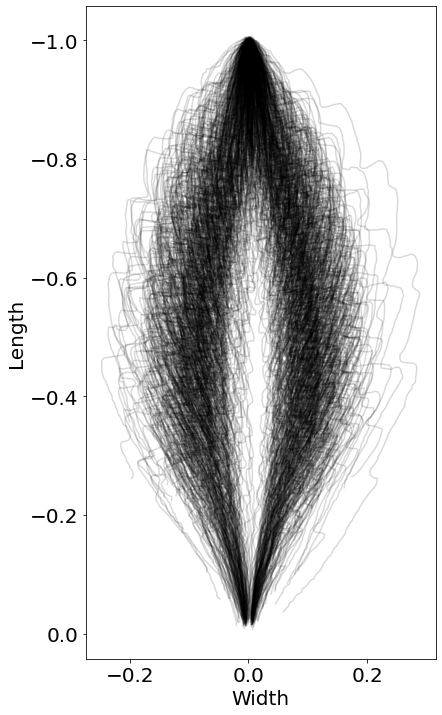

In [47]:
# Iterate through centr_lob_coordinates and plot each set of coordinates
plt.figure(figsize=(12,12))
for i in range(len(list_central_lobe_interpolated)):
    coordinates = list_central_lobe_interpolated[i]
    x_values = [x[0] for x in coordinates]  # Extract x values
    y_values = [y[1] for y in coordinates]  # Extract y values

    # Plot the coordinates for the current element
    plt.plot(x_values, y_values, c="k", alpha=0.15)
    plt.gca().invert_yaxis()

# Add labels, title, legend, or other plot settings as needed
plt.xlabel("Width", fontsize=20)
plt.ylabel("Length", fontsize=20)
plt.tick_params(labelsize=20)
plt.gca().set_aspect("equal")
#plt.savefig("central_lfl_orig.pdf", format="pdf")

In [48]:
# Calculating the min and max values of x and the width
min_x_coor_int = []
max_x_coor_int = []
width = []

for i in range(len(list_central_lobe_interpolated)):
    min_x = np.min(list_central_lobe_interpolated[i][:, 0])
    max_x = np.max(list_central_lobe_interpolated[i][:, 0])
    width_curr = max_x - min_x
    min_x_coor_int.append(min_x)
    max_x_coor_int.append(max_x)
    width.append(width_curr)  

## 10.3. Central leaflet width analysis by Accession, Leaflet number and Relative node number
### 10.3.1. Plot the central leaflet widths

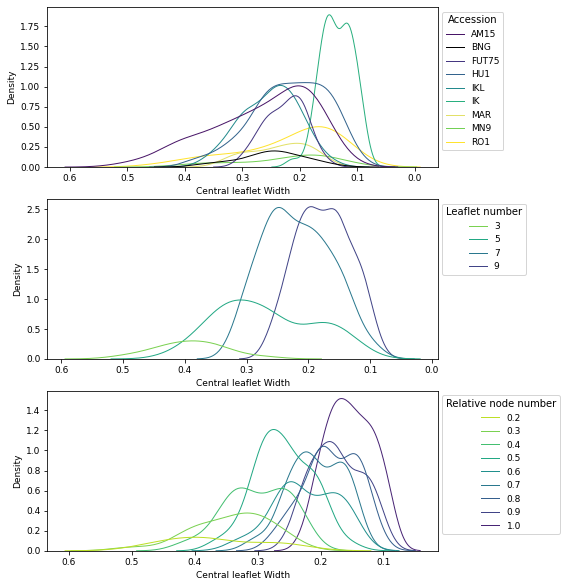

In [49]:
df_pop = pd.DataFrame(list(zip(width, pop_list)),
               columns =['width', 'accession'])

df_lob = pd.DataFrame(list(zip(width, lob_list)),
               columns =['width', 'leaflets'])

df_relnod_list = pd.DataFrame(list(zip(width, relnod_list_int)),
               columns =['width', 'relative node'])

plt.figure(figsize=(7,10))

lnw=1
lbs=9

palette_pop=("#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e")
palette_lob = sns.color_palette("viridis_r", 4)
palette_nd = sns.color_palette("viridis_r", 9)

plt.subplot(3,1,1)
ax=sns.kdeplot(data=df_pop, x=df_pop["width"], hue=df_pop["accession"], palette=palette_pop, lw=lnw)
ax.invert_xaxis()
plt.tick_params(labelsize=lbs)
plt.xlabel("Central leaflet Width", fontsize=lbs)
plt.ylabel("Density", fontsize=lbs)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize= lbs, ncol=1, 
                markerscale=5, title="Accession")

plt.subplot(3,1,2)
ax=sns.kdeplot(data=df_lob, x=df_lob["width"], hue=df_lob["leaflets"], palette=palette_lob, lw=lnw)
ax.invert_xaxis()
plt.tick_params(labelsize=lbs)
plt.xlabel("Central leaflet Width", fontsize=lbs)
plt.ylabel("Density", fontsize=lbs)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize= lbs, ncol=1, 
                markerscale=5, title="Leaflet number")

plt.subplot(3,1,3)
ax=sns.kdeplot(data=df_relnod_list, x=df_relnod_list["width"], hue=df_relnod_list["relative node"], 
                palette=palette_nd, lw=lnw)
ax.invert_xaxis()
plt.tick_params(labelsize=lbs)
plt.xlabel("Central leaflet Width", fontsize=lbs)
plt.ylabel("Density", fontsize=lbs)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize= lbs, ncol=1, 
                markerscale=5, title="Relative node number")

#plt.savefig("width_dens_fig.jpg", bbox_inches='tight')
#plt.savefig("width_dens_fig.pdf", format="pdf", bbox_inches='tight')

### 10.3.2. Calculate Kruskal-Wallis and Dunn post hoc test

In [50]:
# make a dataframe if not done yet (see step 10.3.1.)
# df_pop, df_lob, df_relnod_list

# mask accession levels
AM15 = df_pop["width"][df_pop["accession"]=="AM15"]
BNG = df_pop["width"][df_pop["accession"]=="BNG"]
FUT75 = df_pop["width"][df_pop["accession"]=="FUT75"]
HU1 = df_pop["width"][df_pop["accession"]=="HU1"]
IKL = df_pop["width"][df_pop["accession"]=="IKL"]
IK = df_pop["width"][df_pop["accession"]=="IK"]
MAR = df_pop["width"][df_pop["accession"]=="MAR"]
MN9 = df_pop["width"][df_pop["accession"]=="MN9"]
RO1 = df_pop["width"][df_pop["accession"]=="RO1"]

# mask leaflet levels
L3 = df_lob["width"][df_lob["leaflets"]==3]
L5 = df_lob["width"][df_lob["leaflets"]==5]
L7 = df_lob["width"][df_lob["leaflets"]==7]
L9 = df_lob["width"][df_lob["leaflets"]==9]

# mask relative node levels
R2 = df_relnod_list["width"][df_relnod_list["relative node"]==0.2]
R3 = df_relnod_list["width"][df_relnod_list["relative node"]==0.3]
R4 = df_relnod_list["width"][df_relnod_list["relative node"]==0.4]
R5 = df_relnod_list["width"][df_relnod_list["relative node"]==0.5]
R6 = df_relnod_list["width"][df_relnod_list["relative node"]==0.6]
R7 = df_relnod_list["width"][df_relnod_list["relative node"]==0.7]
R8 = df_relnod_list["width"][df_relnod_list["relative node"]==0.8]
R9 = df_relnod_list["width"][df_relnod_list["relative node"]==0.9]
R10 = df_relnod_list["width"][df_relnod_list["relative node"]==1.0]

# Kruskal-Wallis test
print("Kruskal-Wallis test for accession~width:", 
      stats.kruskal(AM15, BNG, FUT75, HU1, IKL, IK, MAR, MN9, RO1))

print("Kruskal-Wallis test for leaflet~width:", 
      stats.kruskal(L3, L5, L7, L9))

print("Kruskal-Wallis test for relative node~width:", 
      stats.kruskal(R2, R3, R4, R5, R6, R7, R8, R9, R10))

Kruskal-Wallis test for accession~width: KruskalResult(statistic=122.1304190400731, pvalue=1.2035153186998613e-22)
Kruskal-Wallis test for leaflet~width: KruskalResult(statistic=111.22111589703604, pvalue=5.991404893176269e-24)
Kruskal-Wallis test for relative node~width: KruskalResult(statistic=212.095274546587, pvalue=1.7980042415068992e-41)


In [51]:
# Do the Dunn posthoc test with bonferoni correction for the data
data_pop = [AM15, BNG, FUT75, HU1, IKL, IK, MAR, MN9, RO1]
data_lob = [L3, L5, L7, L9]
data_rel = [R2, R3, R4, R5, R6, R7, R8, R9, R10]

# using the posthoc_dunn() function (help(sp.posthoc_dunn))
p_values_pop= sp.posthoc_dunn(data_pop, p_adjust = 'bonferroni')
p_values_lob= sp.posthoc_dunn(data_lob, p_adjust = 'bonferroni')
p_values_rel= sp.posthoc_dunn(data_rel, p_adjust = 'bonferroni')

print("Dunn posthoc for accessions")
print(p_values_pop < 0.05)
print("Dunn posthoc for leaflets")
print(p_values_lob < 0.05)
print("Dunn posthoc for relative nodes")
print(p_values_rel < 0.05)

Dunn posthoc for accessions
       1      2      3      4      5      6      7      8      9
1  False  False  False  False  False   True  False  False  False
2  False  False  False  False  False   True  False  False  False
3  False  False  False  False  False   True  False  False  False
4  False  False  False  False  False   True  False  False  False
5  False  False  False  False  False   True  False  False  False
6   True   True   True   True   True  False   True   True   True
7  False  False  False  False  False   True  False  False  False
8  False  False  False  False  False   True  False  False  False
9  False  False  False  False  False   True  False  False  False
Dunn posthoc for leaflets
       1      2      3      4
1  False   True   True   True
2   True  False   True   True
3   True   True  False   True
4   True   True   True  False
Dunn posthoc for relative nodes
       1      2      3      4      5      6      7      8      9
1  False  False  False  False   True   True   Tru

# 11. COMPARISON WITH THE TRADITIONAL METHOD (shape analysis of central leaflet)
## 11.1 Prepare the data for the LDA analysis

In [52]:
# Convert the list "list_central_lobe_interpolated" with 399 arrays with interpolated coordinates into an array
cent_int_arr = np.array(list_central_lobe_interpolated) # shape: 339, 399, 2

# And then "flatten the array" so that it is now a 2D array, where rows are leaves, and first 399 columns are x coordinates,
# and second 399 columns are y coordinates
list_x_val_cen_int = [] # create new list to store the x values
list_y_val_cen_int = [] # create new liss to store the y values

for i in range(len(cent_int_arr)):
    x_val_cen_int=cent_int_arr[i][:, 0] # extract the x values for the i-th leaf
    y_val_cen_int=cent_int_arr[i][:, 1] # extract the y values for the i-th leaf
    list_x_val_cen_int.append(x_val_cen_int) # append the values to the list
    list_y_val_cen_int.append(y_val_cen_int) # append the values to the list

flat_cent_int_arr = np.column_stack((list_x_val_cen_int, list_y_val_cen_int)) # Combine the both lists, so that now you have
                                                                              # a new array with a shape: 341, 798

#np.shape(flat_cent_int_arr)

## 11.2. LDA analysis
### 11.2.1. By accession

In [53]:
## x is the features we use to predict factor - they are the x and y coordinate values for interpolated central leaflet
x_pop = flat_cent_int_arr

## y is the factor we are predicting - in this case it is accession
y_pop = pop_list

## we create an LDA model for accession from coordiate values and then we fit the model
pop_model = LinearDiscriminantAnalysis()
pop_model.fit(x_pop, y_pop)

## calculate the LDs from the model
pop_LDs = pop_model.fit(x_pop, y_pop).transform(x_pop)

## create a df to plot the data
popLD_df = pd.DataFrame({'LD1':pop_LDs[:,0], 
                      'LD2':pop_LDs[:,1], 
                      'pop':pop_list})

**Leave-One-Out Cross-Validation**

In [54]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_pop = cross_val_score(pop_model, x_pop, y_pop, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_pop), std(scores_pop)))

Accuracy: 0.393 (0.488)


### 11.2.2. By leaflet number

In [55]:
## x is the features we use to predict factor - they are the x and y coordinate values for interpolated central leaflet
x_lob =  flat_cent_int_arr

## y is the factor we are predicting - in this case it is leaflet number
## convert leaflet number to string
y_lob = [str(x) for x in lob_list]

## we create an LDA model for leaflet number from coordiate values and then we fit the model
lob_model = LinearDiscriminantAnalysis()
lob_model.fit(x_lob, y_lob)

## calculate the LDs from the model
lob_LDs = lob_model.fit(x_lob, y_lob).transform(x_lob)

## create a df to plot the data
lobLD_df = pd.DataFrame({'LD1':lob_LDs[:,0], 
                      'LD2':lob_LDs[:,1], 
                      'lob':y_lob})

**Leave-One-Out Cross-Validation**

In [56]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_lob = cross_val_score(lob_model, x_lob, y_lob, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_lob), std(scores_lob)))

Accuracy: 0.528 (0.499)


### 11.2.3. By relative node number

In [57]:
## x is the features we use to predict factor - they are the x and y coordinate values for interpolated central leaflet
x_rel = flat_cent_int_arr

## y is the factor we are predicting - in this case it is relative node number
y_rel = relnod_list

## we create an LDA model for relative node number from coordiate values and then we fit the model
rel_model = LinearDiscriminantAnalysis()
rel_model.fit(x_rel, y_rel)

## calculate the LDs from the model
rel_LDs = rel_model.fit(x_rel, y_rel).transform(x_rel)

## create a df to plot the data
relLD_df = pd.DataFrame({'LD1':rel_LDs[:,0], 
                      'LD2':rel_LDs[:,1], 
                      'rel':y_rel})

**Leave-One-Out Cross-Validation**

In [58]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_rel = cross_val_score(rel_model, x_rel, y_rel, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_rel), std(scores_rel)))

Accuracy: 0.205 (0.404)


## 11.3. PREDICTION ON TRAIN (a) AND TEST (b) DATASETS
### 11.3.1. Prepare the data¶

In [59]:
# Extract the indexes of where leaves with a and c and leaves with b and d are found and save them in a new list of 
# indexes for leaves ind_a and ind_b and check the length

def find_ac(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch or ltr == 'c']

def find_bd(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch or ltr == 'd']

leaf_a = find_ac(nodab_list, "a")
leaf_b = find_bd(nodab_list, "b")

# Extract the rows with width values for with leaves a and b into a separate array.
new_arr_a = flat_cent_int_arr[leaf_a]
new_arr_b = flat_cent_int_arr[leaf_b]

### 11.3.2. Train the model on a and predict the b leaves and plot confusion matrix
#### 11.3.2.1. By Accession

In [60]:
## x is the features we use to predict factor, in this case interpolated coordinates for central leaflet
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting, in this case it is accession
y_a = pop_list_a
y_b = pop_list_b

## we create an LDA model for accession from central leaflet shape and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_pop= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_pop)]

count_true_ca = comparison_result.count(True)
count_false_ca = comparison_result.count(False)
print("Count of True values for accession:", count_true_ca)
print("Count of False values for accession:", count_false_ca)

## Plot a confusion matrix

# True values
true_values = pop_list_b

# Predicted values
predicted_values = prediction_pop

# Create confusion matrix
cm_pop = confusion_matrix(true_values, predicted_values)

Count of True values for accession: 76
Count of False values for accession: 85


#### 11.3.2.2. By Leaflet number

In [61]:
## x is the features we use to predict factor, in this case interpolated coordinates for central leaflet
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting - in this case it is leaflet number
y_a = lob_list_a
y_b = lob_list_b

## we create an LDA model for leaflet number from coordiate values and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_lob= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_lob)]

count_true_cl = comparison_result.count(True)
count_false_cl = comparison_result.count(False)
print("Count of True values for leaflet number:", count_true_cl)
print("Count of False values for leaflet number:", count_false_cl)

## Plot a confusion matrix

# True values
true_values = lob_list_b

# Predicted values
predicted_values = prediction_lob

# Create confusion matrix
cm_lob = confusion_matrix(true_values, predicted_values)

Count of True values for leaflet number: 93
Count of False values for leaflet number: 68


#### 11.3.2.3. By Relative node number

In [62]:
## x is the features we use to predict factor, in this case interpolated coordinates for central leaflet
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting - in this case it is relative node number
y_a = relnod_list_a
y_b = relnod_list_b

## we create an LDA model for relative node number from coordiate values and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_relnod= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_relnod)]

count_true_cr = comparison_result.count(True)
count_false_cr = comparison_result.count(False)
print("Count of True values for relative node:", count_true_cr)
print("Count of False values for relative node:", count_false_cr)

## Plot a confusion matrix

# True values
true_values = relnod_list_b

# Predicted values
predicted_values = prediction_relnod

# Create confusion matrix
cm_rel = confusion_matrix(true_values, predicted_values)

Count of True values for relative node: 39
Count of False values for relative node: 122


**And calculate Spearman Rank correlation**

In [63]:
rho, p = spearmanr(relnod_list_b, prediction_relnod)

#print Spearman rank correlation and p-value
print(rho)
print(p)
rho_c = rho
p_c = p

0.6293987977258088
3.818411958379197e-19


## 11.4. Plot the LDAs and Confusion matrices for central leaflet shapes

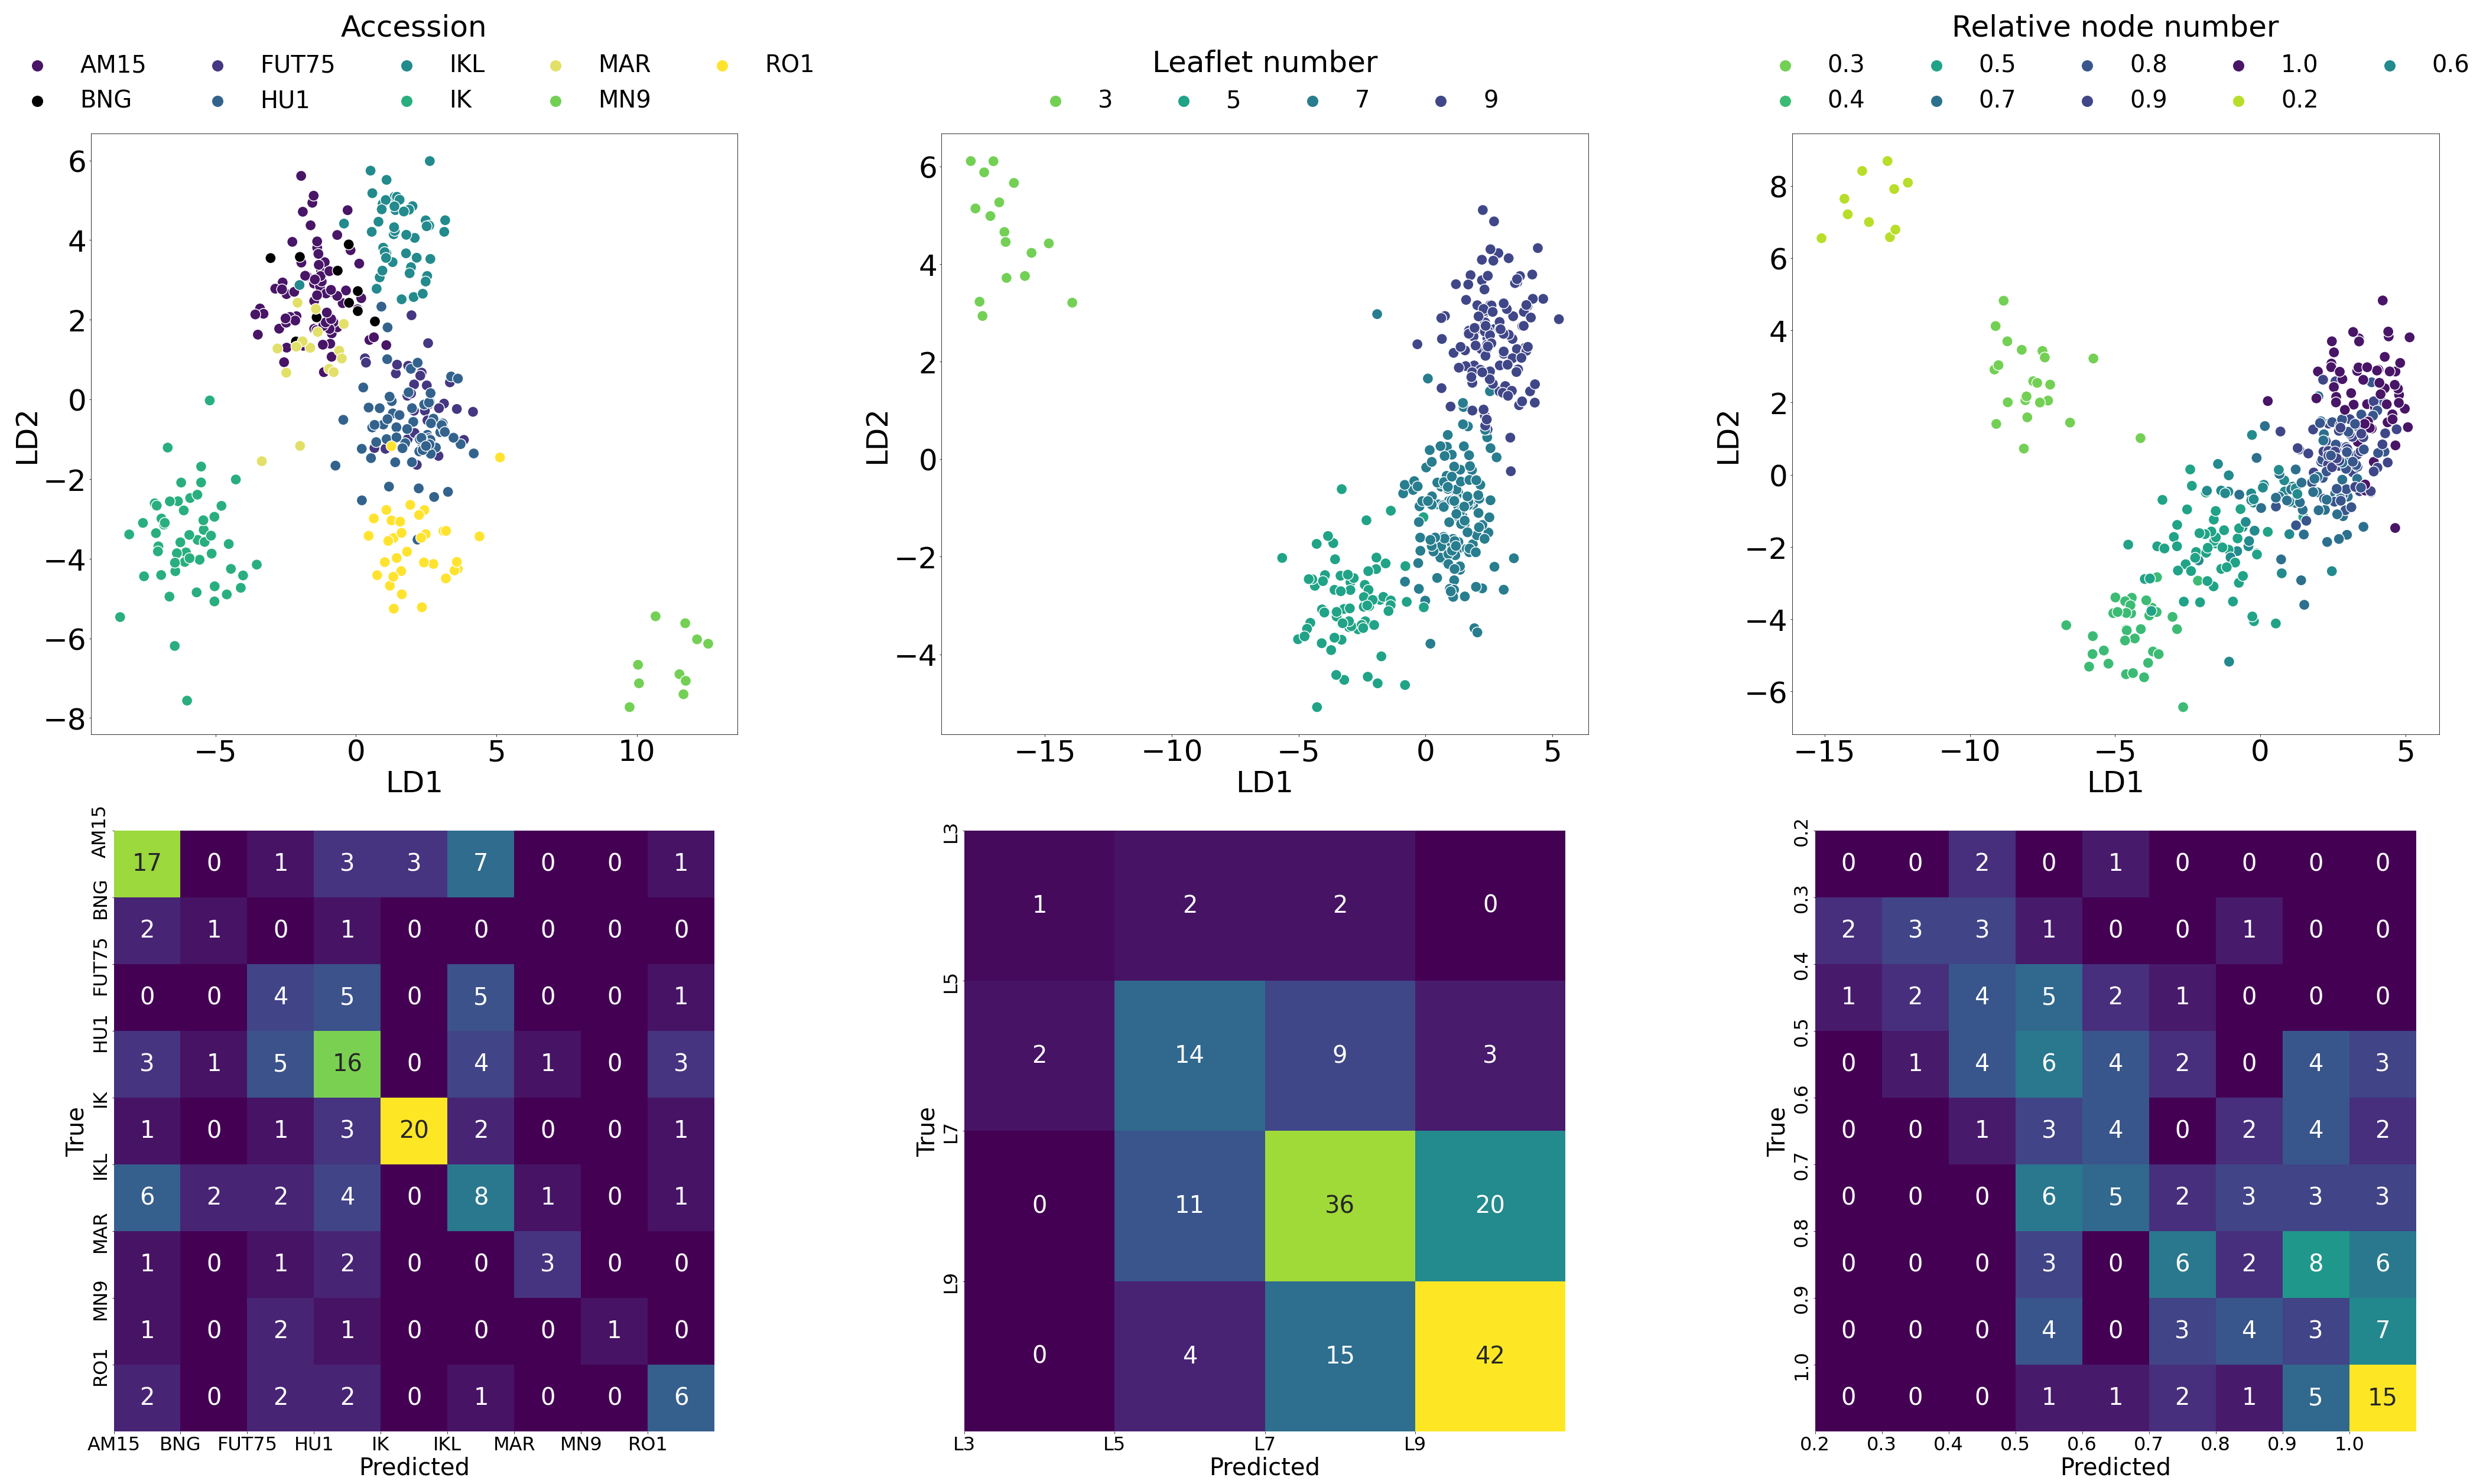

In [64]:
palette_pop=("#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e")
palette_lob=("#73d055", "#20a387", "#287d8e", "#404788")
palette_rel_node=("#73d055", "#3cbb75", "#20a387", "#2d708e", "#39568c", "#404788", "#481567", "#b8de29", "#238a8d")

# Parameters for LDAs
pt_s=330
lbs=50
mkscl=3
lbs_leg=40

# Parameters for Confusion matrices
fs=40
ls=32
fs_m=40

plt.figure(figsize=(60,35))

plt.subplot(2,3,1)
ax=sns.scatterplot(data=popLD_df, x="LD1", y="LD2", hue="pop", s=pt_s, palette=palette_pop, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Accession", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 

plt.subplot(2,3,2)
ax=sns.scatterplot(data=lobLD_df, x="LD1", y="LD2", hue="lob", s=pt_s, palette=palette_lob, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Leaflet number", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 

plt.subplot(2,3,3)
ax=sns.scatterplot(data=relLD_df, x="LD1", y="LD2", hue="rel", s=pt_s, palette=palette_rel_node, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Relative node number", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 


plt.subplot(2,3,4)
ax=sns.heatmap(cm_pop, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Adjust as needed
custom_labels_y = ["AM15", "BNG", "FUT75", "HU1", "IK", "IKL", "MAR", "MN9", "RO1"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.subplot(2,3,5)
ax=sns.heatmap(cm_lob, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3]  # Adjust as needed
custom_labels_y = ["L3", "L5", "L7", "L9"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.subplot(2,3,6)
ax=sns.heatmap(cm_rel, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Adjust as needed
custom_labels_y = ["0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.tight_layout()
#plt.savefig("lda_conf_matrix_central_lfl_shape.jpg")
#plt.savefig("lda_conf_matrix_central_lfl_shape.pdf", format="pdf", bbox_inches='tight')

# 12. COMBINED DATASET OF ORIGINAL COORDINATES FOR CENTRAL LEAFLET AND COORDINATES OF THE RECONSTRUCTED LEAVES (2ND DEGREE POLYNOMIAL MODELS) 
## 12.1. Prepare the data

To see if a combined dataset of the interpolated original coordinates of the central leaflet (**flat_cent_int_arr**) and the coordinates of the reconstructed leaf (**flat_coord_arr**) predict the leaf identity better, we first need to concatenate the two datasets.

1. **flat_cent_int_arr** - Original and central leaflet
Shape: (341, 798) - 341 leaves and 399*2 coordinates (2 for x and y)

2. **flat_coord_arr** - reconstructed and whole leaf
Shape: (341, 7182) - 341 leaves and 339*2*9 coordinates (2 for x and y, and 9 for 9 modeled leaflets)  
  
3. NEW ARRAY: **concat_arr** - the new combined dataset
Shape: (341, 7980) - 341 leaves and 798+7182 coordinates

In [65]:
#np.shape(flat_cent_int_arr) # Original and central leaflet
#np.shape(flat_coord_arr) # Reconstructed and whole leaf

# Concatenate the two datasets:
concat_arr = np.concatenate((flat_cent_int_arr, flat_coord_arr), axis=1)
#np.shape(concat_arr)

## 12.2. LDA analysis
### 12.2.1. By accession

In [66]:
## x is the features we use to predict factor - they are the coordinates of the combined dataset
x_pop = concat_arr

## y is the factor we are predicting - in this case it is accession
y_pop = pop_list

## we create an LDA model for accession from coordiate values and then we fit the model
pop_model = LinearDiscriminantAnalysis()
pop_model.fit(x_pop, y_pop)

## calculate the LDs from the model
pop_LDs = pop_model.fit(x_pop, y_pop).transform(x_pop)

## create a df to plot the data
popLD_df = pd.DataFrame({'LD1':pop_LDs[:,0], 
                      'LD2':pop_LDs[:,1], 
                      'pop':pop_list})

**Leave-One-Out Cross-Validation**

In [67]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_pop = cross_val_score(pop_model, x_pop, y_pop, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_pop), std(scores_pop)))

Accuracy: 0.742 (0.438)


### 12.2.2. By leaflet number

In [68]:
## x is the features we use to predict factor - they are the coordinates of the combined dataset
x_lob =  concat_arr

## y is the factor we are predicting - in this case it is leaflet number
## convert leaflet number to string
y_lob = [str(x) for x in lob_list]

## we create an LDA model for leaflet number from coordiate values and then we fit the model
lob_model = LinearDiscriminantAnalysis()
lob_model.fit(x_lob, y_lob)

## calculate the LDs from the model
lob_LDs = lob_model.fit(x_lob, y_lob).transform(x_lob)

## create a df to plot the data
lobLD_df = pd.DataFrame({'LD1':lob_LDs[:,0], 
                      'LD2':lob_LDs[:,1], 
                      'lob':y_lob})

**Leave-One-Out Cross-Validation**

In [69]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_lob = cross_val_score(lob_model, x_lob, y_lob, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_lob), std(scores_lob)))

Accuracy: 0.985 (0.120)


### 12.2.3. By relative node number

In [70]:
## x is the features we use to predict factor - they are the coordinates of the combined dataset
x_rel = concat_arr

## y is the factor we are predicting - in this case it is relative node number
y_rel = relnod_list

## we create an LDA model for relative node number from coordiate values and then we fit the model
rel_model = LinearDiscriminantAnalysis()
rel_model.fit(x_rel, y_rel)

## calculate the LDs from the model
rel_LDs = rel_model.fit(x_rel, y_rel).transform(x_rel)

## create a df to plot the data
relLD_df = pd.DataFrame({'LD1':rel_LDs[:,0], 
                      'LD2':rel_LDs[:,1], 
                      'rel':y_rel})

**Leave-One-Out Cross-Validation**

In [71]:
# create leave-one-out cv procedure
cv = LeaveOneOut()

# evaluate model
scores_rel = cross_val_score(rel_model, x_rel, y_rel, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_rel), std(scores_rel)))

Accuracy: 0.296 (0.457)


## 12.3. PREDICTION ON TRAIN (a) AND TEST (b) DATASETS
### 12.3.1. Prepare the data

In [72]:
# Extract the indexes of where leaves with a and c and leaves with b and d are found and save them in a new list of 
# indexes for leaves ind_a and ind_b and check the length

def find_ac(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch or ltr == 'c']

def find_bd(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch or ltr == 'd']

leaf_a = find_ac(nodab_list, "a")
leaf_b = find_bd(nodab_list, "b")

# Extract the rows with width values for with leaves a and b into a separate array.
new_arr_a = concat_arr[leaf_a]
new_arr_b = concat_arr[leaf_b]

### 12.3.2. Train the model on a and predict the b leaves and plot confusion matrix
#### 12.3.2.1. By Accession

In [73]:
## x is the features we use to predict factor, in this case the combined dataset
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting, in this case it is accession
y_a = pop_list_a
y_b = pop_list_b

## we create an LDA model for accession from the combined dataset and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_pop= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_pop)]

count_true_coa = comparison_result.count(True)
count_false_coa = comparison_result.count(False)
print("Count of True values for accession:", count_true_coa)
print("Count of False values for accession:", count_false_coa)

## Plot a confusion matrix

# True values
true_values = pop_list_b

# Predicted values
predicted_values = prediction_pop

# Create confusion matrix
cm_pop = confusion_matrix(true_values, predicted_values)

Count of True values for accession: 115
Count of False values for accession: 46


#### 12.3.2.2. By Leaflet number

In [74]:
## x is the features we use to predict factor, in this case the combined dataset
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting - in this case it is leaflet number
y_a = lob_list_a
y_b = lob_list_b

## we create an LDA model for leaflet number from combined dataset and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_lob= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_lob)]

count_true_col = comparison_result.count(True)
count_false_col = comparison_result.count(False)
print("Count of True values for leaflet number:", count_true_col)
print("Count of False values for leaflet number:", count_false_col)

## Plot a confusion matrix

# True values
true_values = lob_list_b

# Predicted values
predicted_values = prediction_lob

# Create confusion matrix
cm_lob = confusion_matrix(true_values, predicted_values)

Count of True values for leaflet number: 161
Count of False values for leaflet number: 0


#### 12.3.2.3. By Relative node number

In [75]:
## x is the features we use to predict factor, in this case the combined dataset
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting - in this case it is relative node number
y_a = relnod_list_a
y_b = relnod_list_b

## we create an LDA model for relative node number from combined dataset and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_relnod= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_relnod)]

count_true_cor = comparison_result.count(True)
count_false_cor = comparison_result.count(False)
print("Count of True values for relative node:", count_true_cor)
print("Count of False values for relative node:", count_false_cor)

## Plot a confusion matrix

# True values
true_values = relnod_list_b

# Predicted values
predicted_values = prediction_relnod

# Create confusion matrix
cm_rel = confusion_matrix(true_values, predicted_values)

Count of True values for relative node: 49
Count of False values for relative node: 112


**And calculate Spearman Rank correlation**  

In [76]:
#calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(relnod_list_b, prediction_relnod)

#print Spearman rank correlation and p-value
print(rho)
print(p)
rho_co = rho
p_co = p

0.787297407214303
3.238654141847503e-35


## 12.4. Plot the LDAs and Confusion matrices for the combined dataset

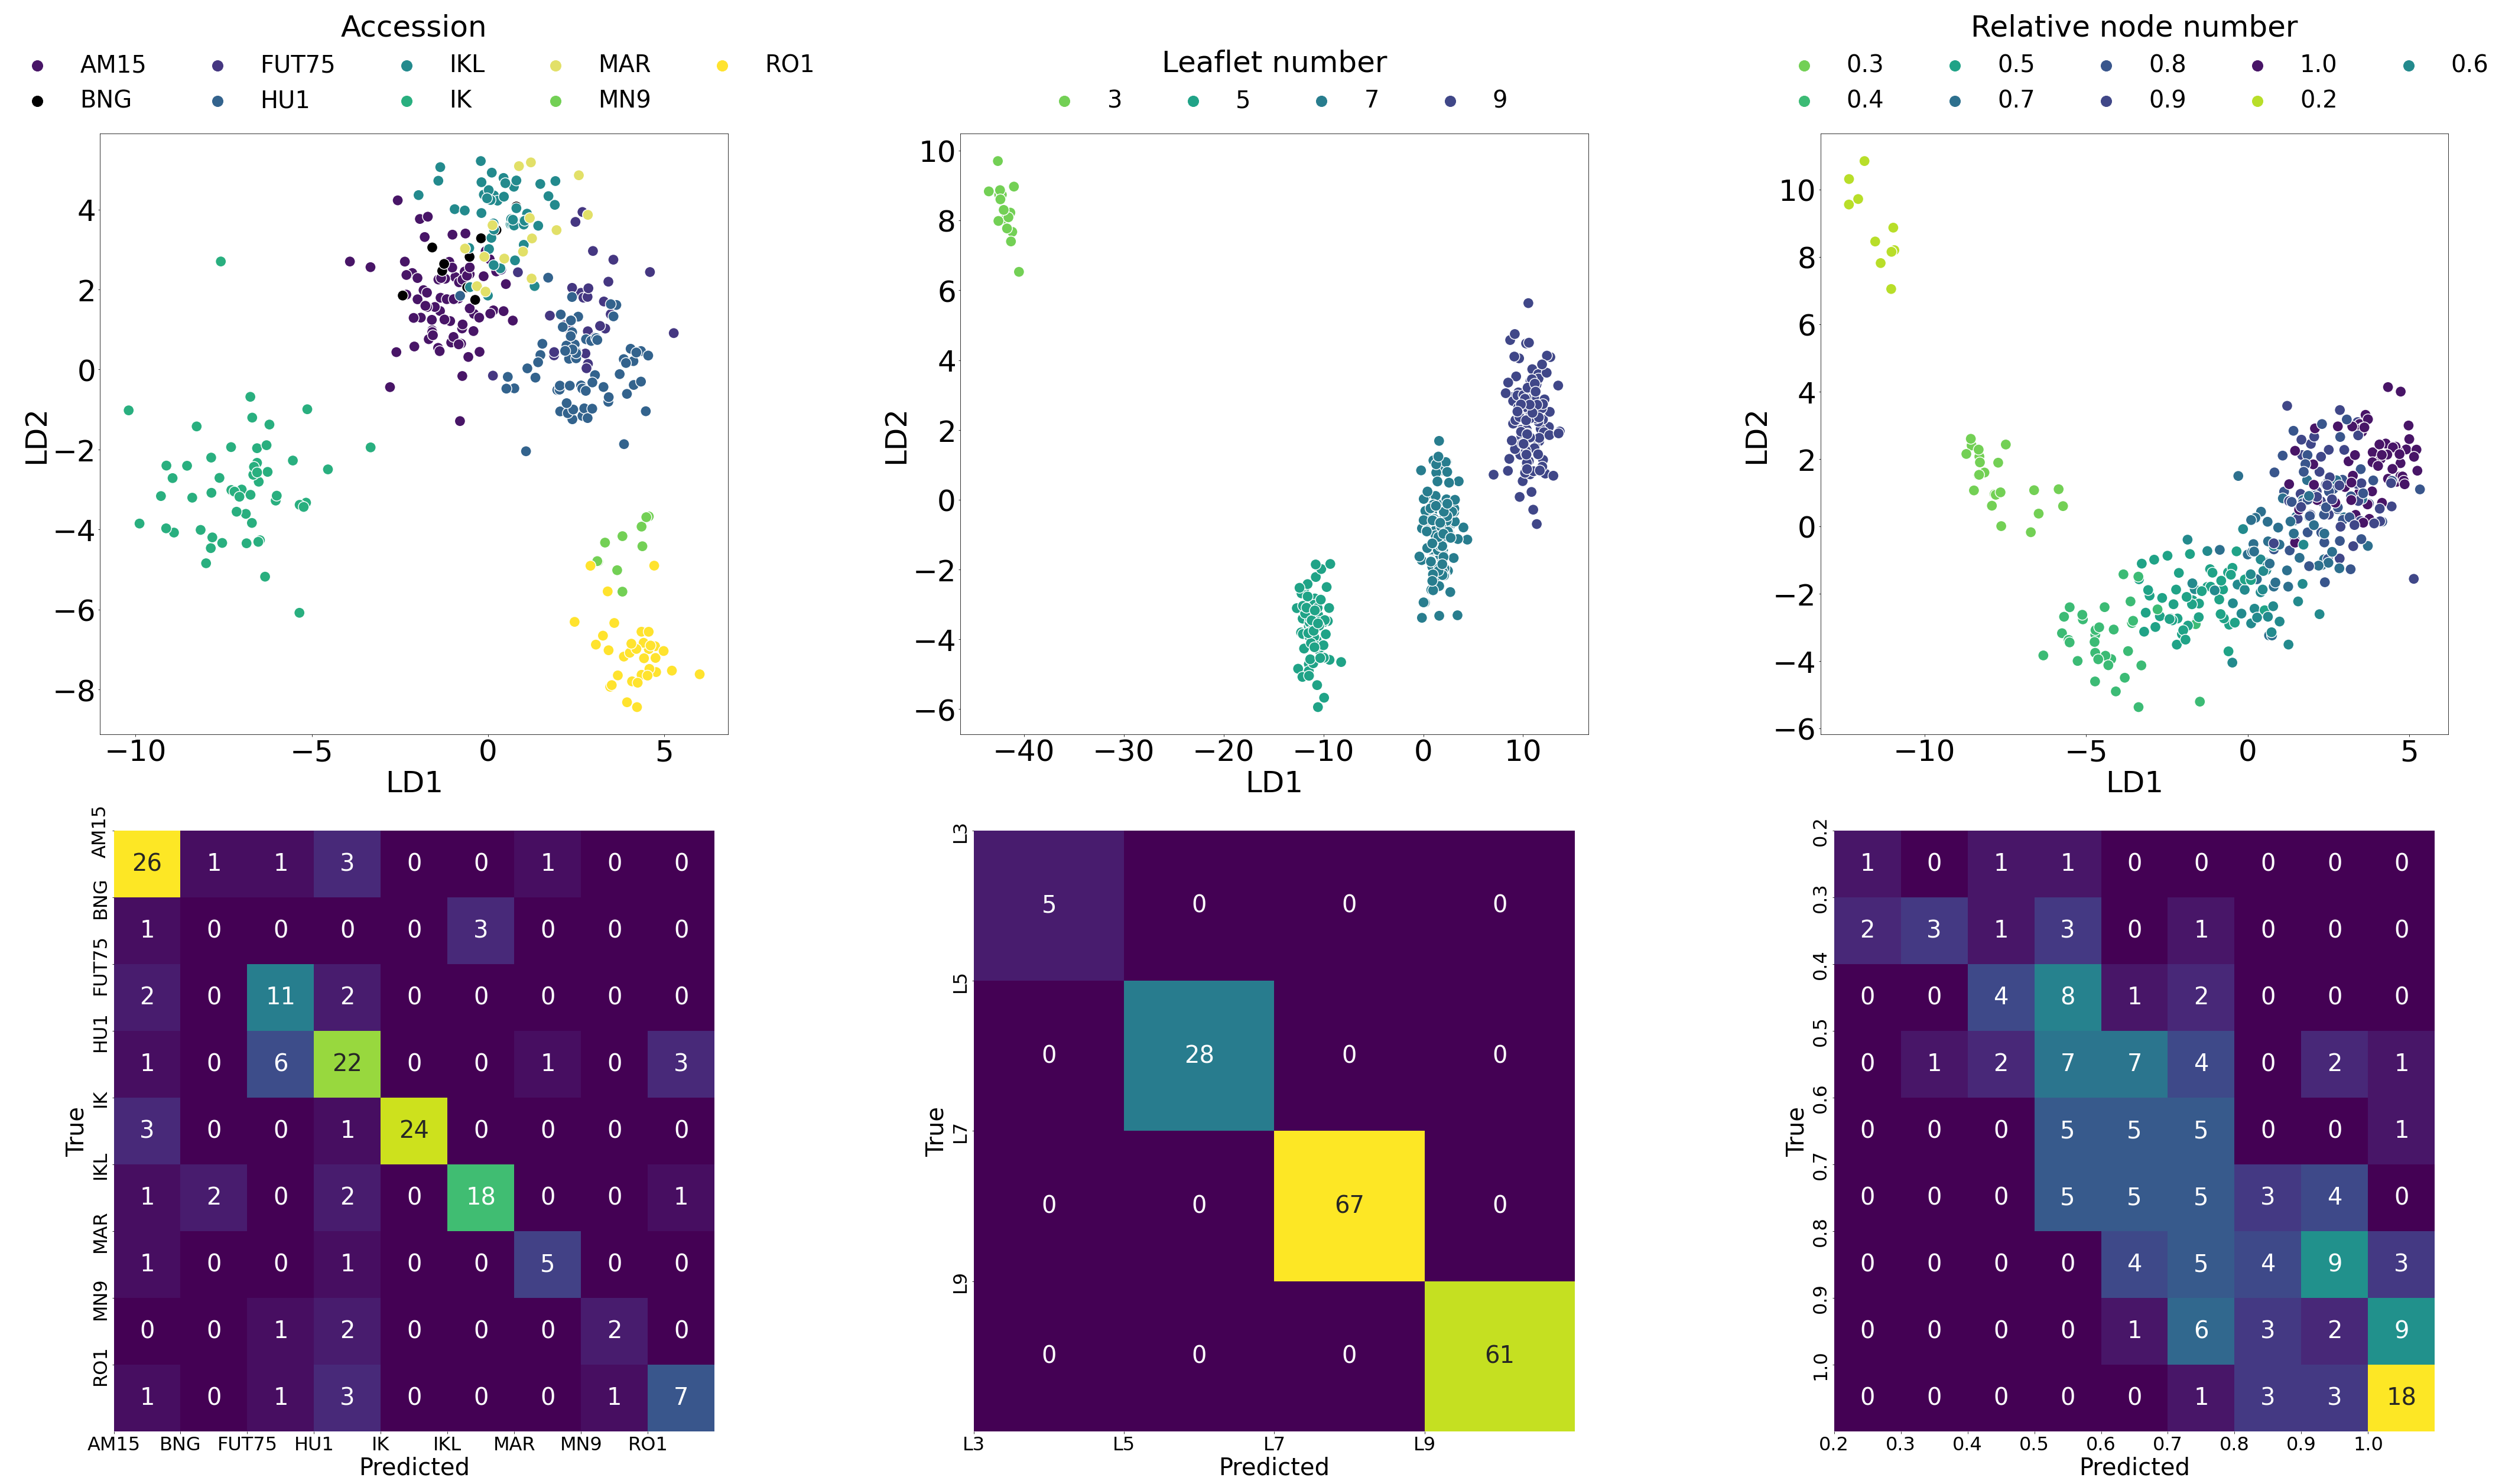

In [77]:
palette_pop=("#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e")
palette_lob=("#73d055", "#20a387", "#287d8e", "#404788")
palette_rel_node=("#73d055", "#3cbb75", "#20a387", "#2d708e", "#39568c", "#404788", "#481567", "#b8de29", "#238a8d")

# Parameters for LDAs
pt_s=330
lbs=50
mkscl=3
lbs_leg=40

# Parameters for Confusion matrices
fs=40
ls=32
fs_m=40

plt.figure(figsize=(60,35))

plt.subplot(2,3,1)
ax=sns.scatterplot(data=popLD_df, x="LD1", y="LD2", hue="pop", s=pt_s, palette=palette_pop, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Accession", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 

plt.subplot(2,3,2)
ax=sns.scatterplot(data=lobLD_df, x="LD1", y="LD2", hue="lob", s=pt_s, palette=palette_lob, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Leaflet number", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 

plt.subplot(2,3,3)
ax=sns.scatterplot(data=relLD_df, x="LD1", y="LD2", hue="rel", s=pt_s, palette=palette_rel_node, alpha=1, legend=True)
ax.set_xlabel("LD1", fontsize=lbs)
ax.set_ylabel("LD2", fontsize=lbs)
ax.tick_params(labelsize=lbs)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= lbs_leg, ncol=5, 
                markerscale=mkscl, title="Relative node number", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize=lbs) 

plt.subplot(2,3,4)
ax=sns.heatmap(cm_pop, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Adjust as needed
custom_labels_y = ["AM15", "BNG", "FUT75", "HU1", "IK", "IKL", "MAR", "MN9", "RO1"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.subplot(2,3,5)
ax=sns.heatmap(cm_lob, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3]  # Adjust as needed
custom_labels_y = ["L3", "L5", "L7", "L9"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.subplot(2,3,6)
ax=sns.heatmap(cm_rel, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": fs_m}, cbar=False)
ax.set_xlabel("Predicted", fontsize=fs)
ax.set_ylabel("True", fontsize=fs)
ax.tick_params(labelsize=ls)
custom_ticks_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Adjust as needed
custom_labels_y = ["0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]  # Adjust as needed
plt.xticks(custom_ticks_y, custom_labels_y)
plt.yticks(custom_ticks_y, custom_labels_y)

plt.tight_layout()
#plt.savefig("lda_conf_matrix_combo.jpg")
#plt.savefig("lda_conf_matrix_combo.pdf", format="pdf", bbox_inches='tight')

# 13. Test which is the best leaflet number for the LDA model prediction

Change the leaflet number in the 5.4. section (**num_leaflets = 9**) from 3 to 15. 

In [78]:
first_line = ['Accession', 'Leaflet number', 'Relative node number', 'Rho', 'p']

true_p = [count_true_pa, count_true_pl, count_true_pr, rho_p, p_p]
false_p = [count_false_pa, count_false_pl, count_false_pr, None, None]

true_c = [count_true_ca, count_true_cl, count_true_cr, rho_c, p_c]
false_c = [count_false_ca, count_false_cl, count_false_cr, None, None]

true_co = [count_true_coa, count_true_col, count_true_cor, rho_co, p_co]
false_co = [count_false_coa, count_false_col, count_false_cor, None, None]

table = pd.DataFrame({
    'True_p': true_p,
    'True_c': true_c,
    'True_co': true_co,
    'False_p': false_p,
    'False_c': false_c,
    'False_co': false_co
},index= (first_line))

In [79]:
table['Total_p'] = table['True_p'] + table['False_p']
table['Total_c'] = table['True_c'] + table['False_c']
table['Total_co'] = table['True_co'] + table['False_co']

table['% True_p'] = table['True_p']*100/table['Total_p']
table['% True_c'] = table['True_c']*100/table['Total_c']
table['% True_co'] = table['True_co']*100/table['Total_co']

In [80]:
#table.to_csv('table_'+str(num_leaflets)+'.csv')